In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import xgboost as xgb

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

sns.set()

In [2]:
# !pip install prophet
# !pip install xgboost

In [3]:
%matplotlib inline
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (12, 4)
plt.style.use("ggplot")
pd.options.display.precision = 4

# 1 EDA

In [4]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", sep=",")

In [5]:
df.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [7]:
df.describe()

temp     rain_1h     snow_1h  clouds_all  traffic_volume
count  48204.0000  48204.0000  48204.0000  48204.0000      48204.0000
mean     281.2059      0.3343      0.0002     49.3622       3259.8184
std       13.3382     44.7891      0.0082     39.0158       1986.8607
min        0.0000      0.0000      0.0000      0.0000          0.0000
25%      272.1600      0.0000      0.0000      1.0000       1193.0000
50%      282.4500      0.0000      0.0000     64.0000       3380.0000
75%      291.8060      0.0000      0.0000     90.0000       4933.0000
max      310.0700   9831.3000      0.5100    100.0000       7280.0000

### Some basic data formattings

In [8]:
df = df.drop(['rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description'], axis=1)

In [9]:
# Convert and set date_time as index
df['date_time'] =  pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index(pd.DatetimeIndex(df['date_time']))

In [10]:
# From kelvin to celcius
df['temp'] = df['temp'].apply(lambda x: x - 273.15)

# Encode holiday values
df['holiday'] = df['holiday'].apply(lambda x: 0 if x == 'None' else 1)

In [11]:
df.head()

holiday   temp           date_time  traffic_volume
date_time                                                              
2012-10-02 09:00:00        0  15.13 2012-10-02 09:00:00            5545
2012-10-02 10:00:00        0  16.21 2012-10-02 10:00:00            4516
2012-10-02 11:00:00        0  16.43 2012-10-02 11:00:00            4767
2012-10-02 12:00:00        0  16.98 2012-10-02 12:00:00            5026
2012-10-02 13:00:00        0  17.99 2012-10-02 13:00:00            4918

### Visualize existing data

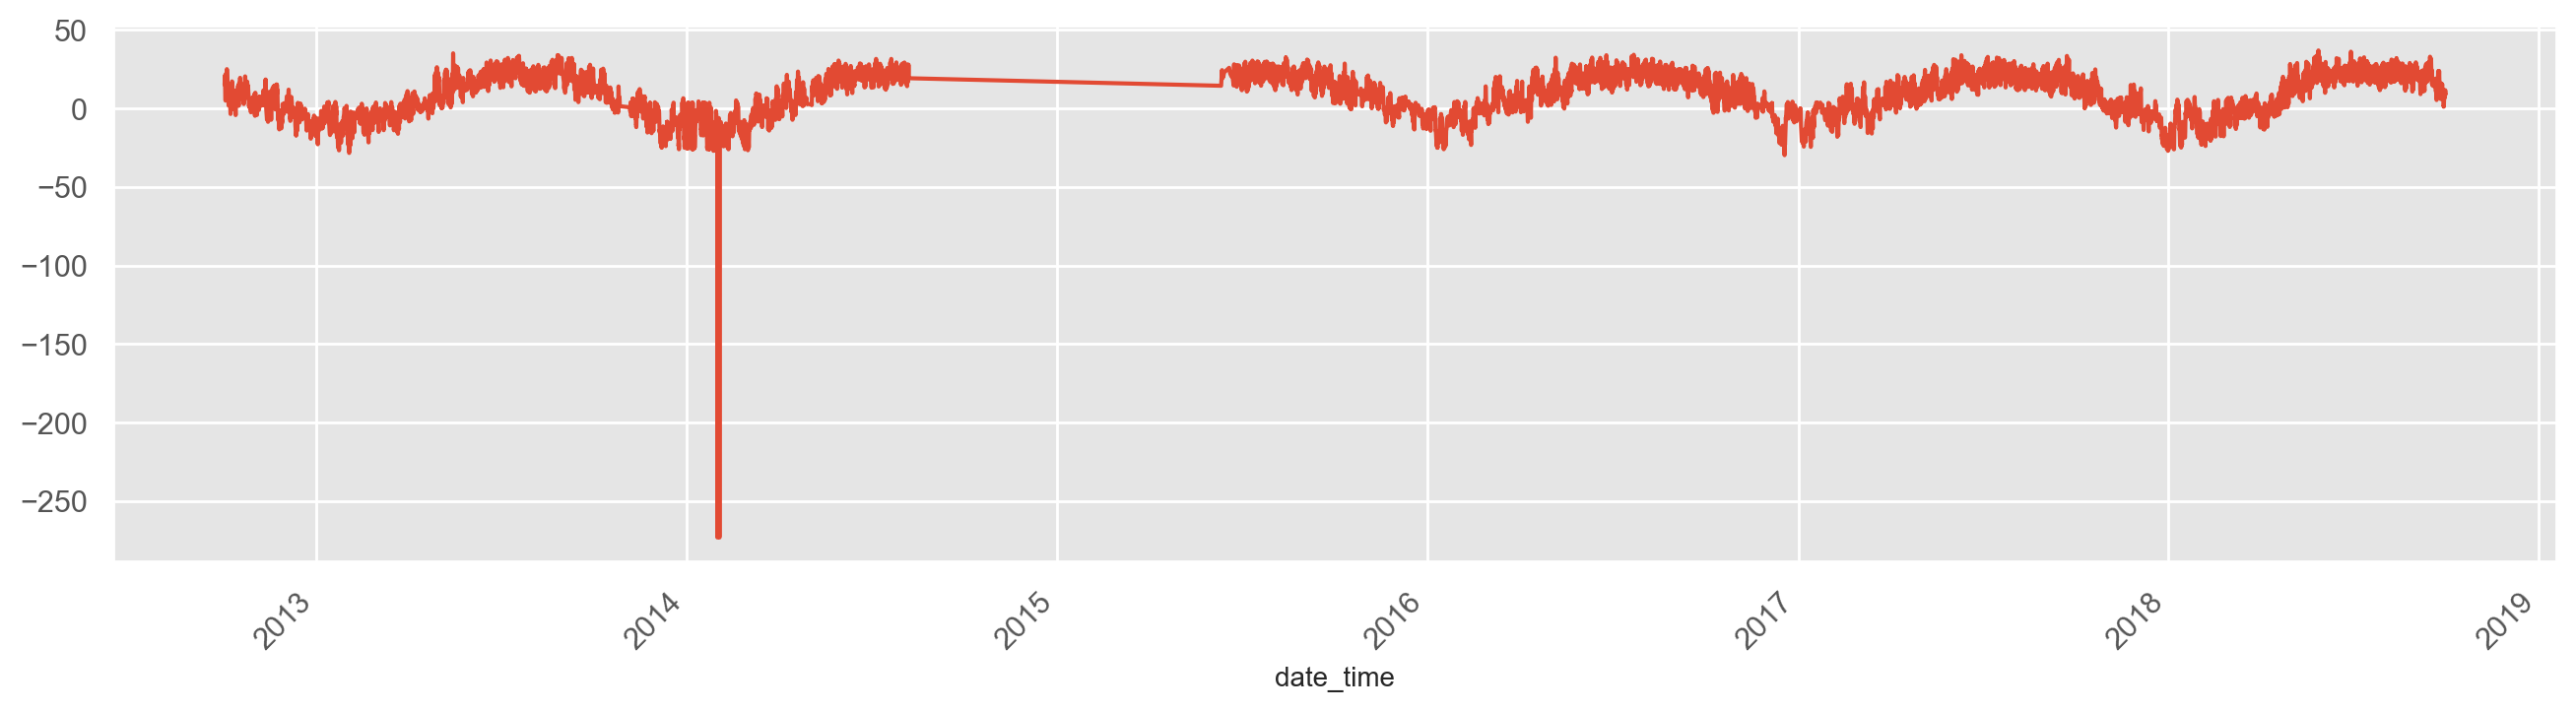

In [12]:
def plot_data(df):
    df.plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.show()

plot_data(df['temp'])

In [13]:
# 0 Kelvins looks a bit cold for public transportation, let's fix it
df['temp'] = df['temp'].apply(lambda x: df['temp'].mean() if (x < -50 or x > 50) else x)

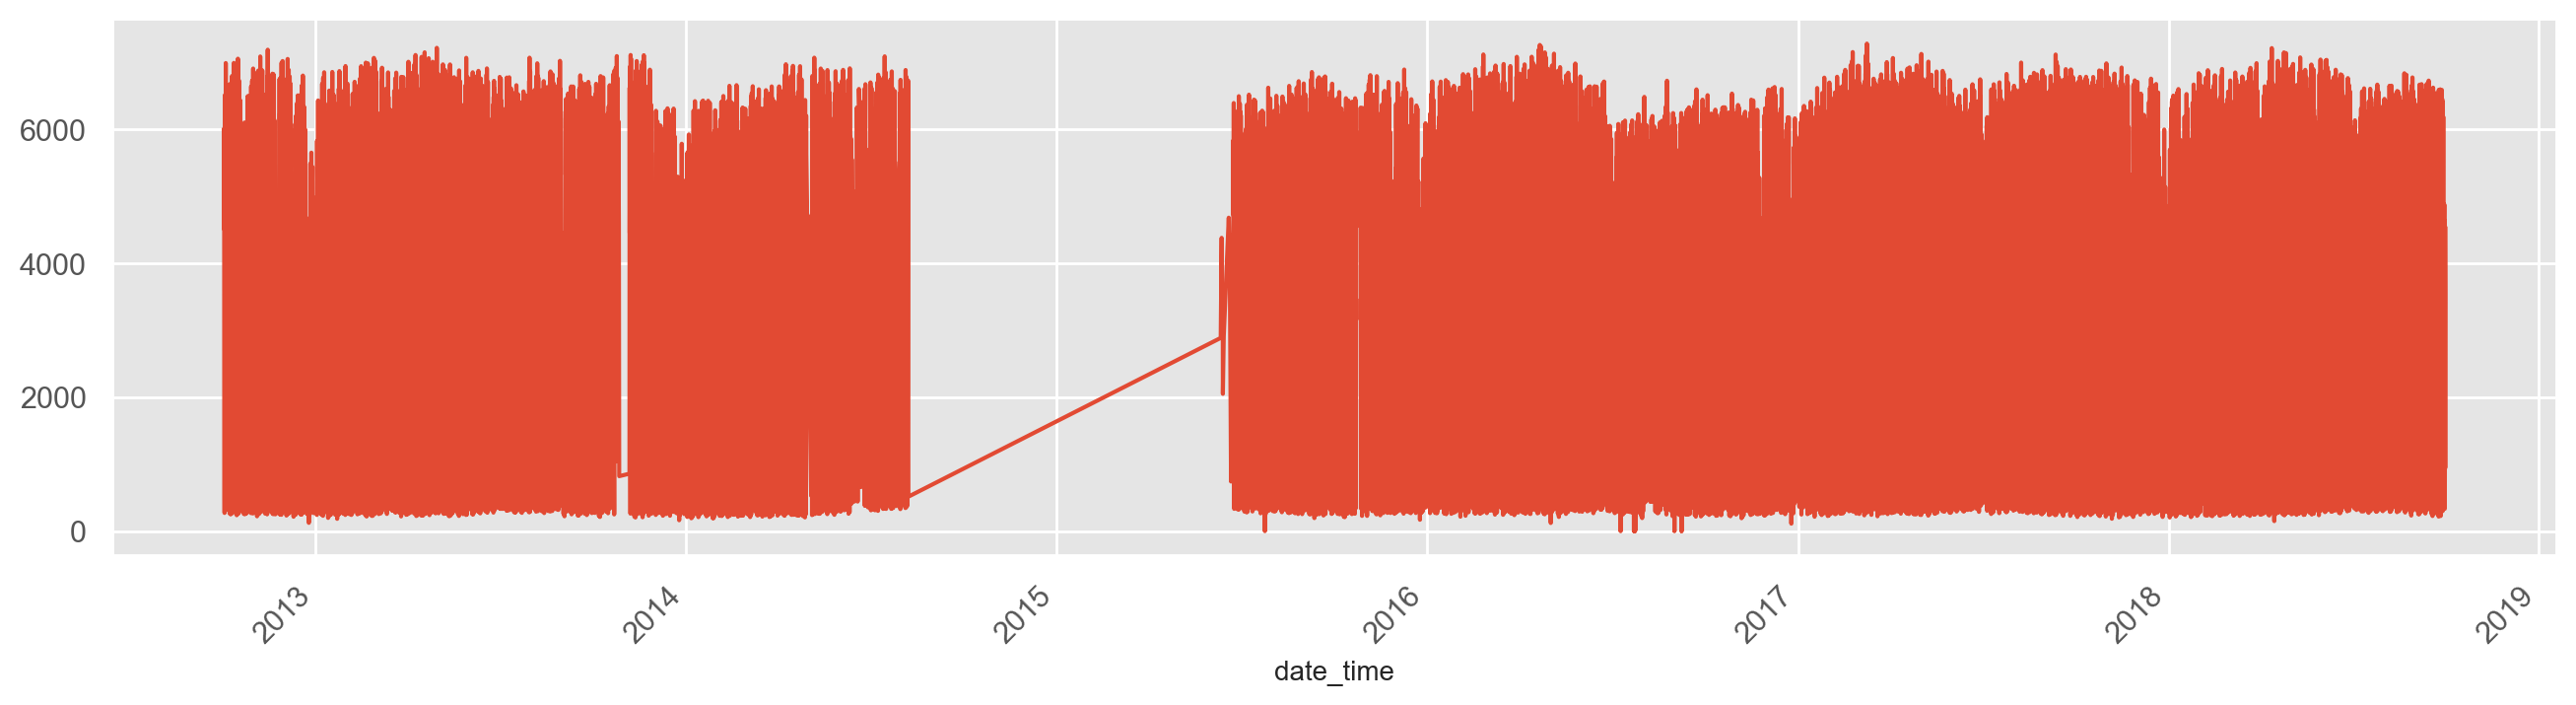

In [14]:
plot_data(df['traffic_volume'])

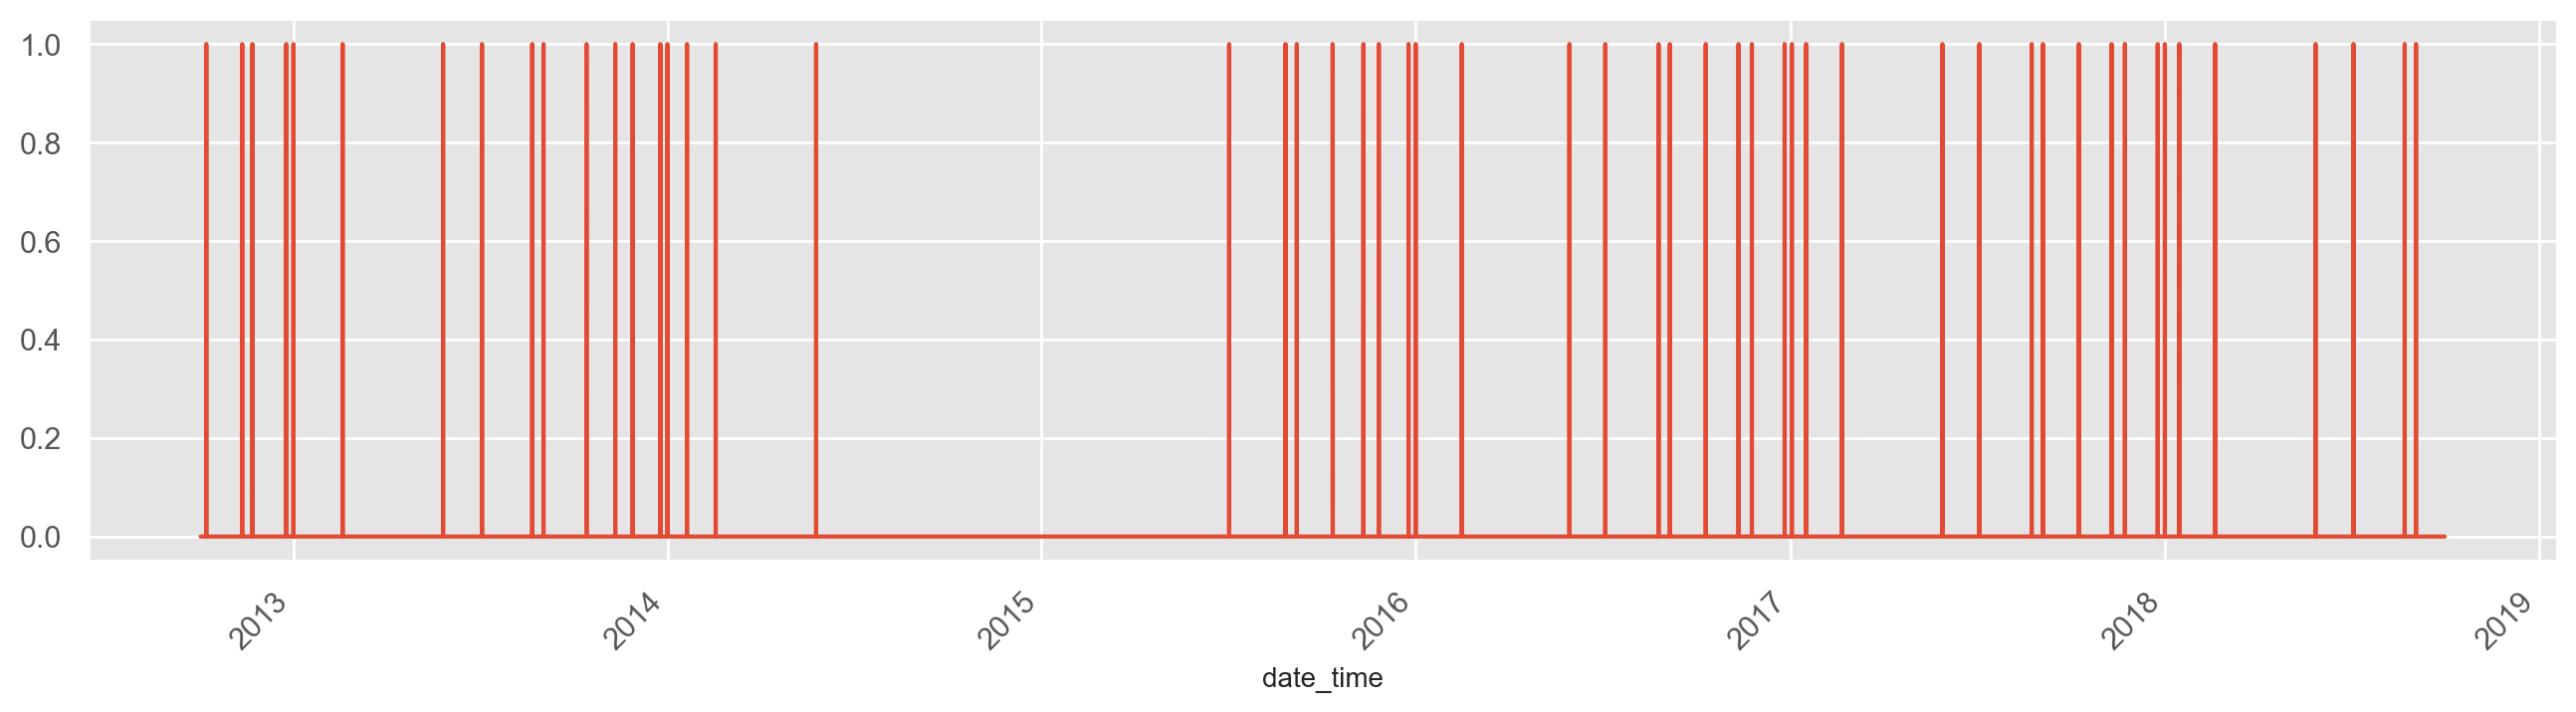

In [15]:
plot_data(df['holiday'])

### Remove duplicates

In [16]:
df.duplicated().sum()

7551

In [17]:
df.shape

(48204, 4)

In [18]:
df = df.drop_duplicates(subset=['date_time'])

In [19]:
df.duplicated().sum()

0

In [20]:
df.shape

(40575, 4)

### Fill empty ranges

In [21]:
skipped_values = len(pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')) - len(df['date_time'])

print(f"Skipped values in dataset: {skipped_values}")

Skipped values in dataset: 11976


In [22]:
data = pd.DataFrame({'real_date_time': pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')})
data['date_time'] =  pd.to_datetime(data['real_date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index(pd.DatetimeIndex(data['date_time']))
data.head()

real_date_time           date_time
date_time                                                  
2012-10-02 09:00:00 2012-10-02 09:00:00 2012-10-02 09:00:00
2012-10-02 10:00:00 2012-10-02 10:00:00 2012-10-02 10:00:00
2012-10-02 11:00:00 2012-10-02 11:00:00 2012-10-02 11:00:00
2012-10-02 12:00:00 2012-10-02 12:00:00 2012-10-02 12:00:00
2012-10-02 13:00:00 2012-10-02 13:00:00 2012-10-02 13:00:00

In [23]:
print(f"Check diff: {len(data) - len(df)}")

Check diff: 11976


In [24]:
data = data.drop(columns=['date_time'], axis=1)

In [25]:
df_new = data.merge(df, how='left', left_on='real_date_time', right_index=True)
df_new = df_new.set_index('real_date_time')

In [26]:
len(df_new)

52551

In [27]:
df_new.head()

holiday   temp           date_time  traffic_volume
real_date_time                                                         
2012-10-02 09:00:00      0.0  15.13 2012-10-02 09:00:00          5545.0
2012-10-02 10:00:00      0.0  16.21 2012-10-02 10:00:00          4516.0
2012-10-02 11:00:00      0.0  16.43 2012-10-02 11:00:00          4767.0
2012-10-02 12:00:00      0.0  16.98 2012-10-02 12:00:00          5026.0
2012-10-02 13:00:00      0.0  17.99 2012-10-02 13:00:00          4918.0

In [28]:
df = df_new.interpolate(method='ffill')

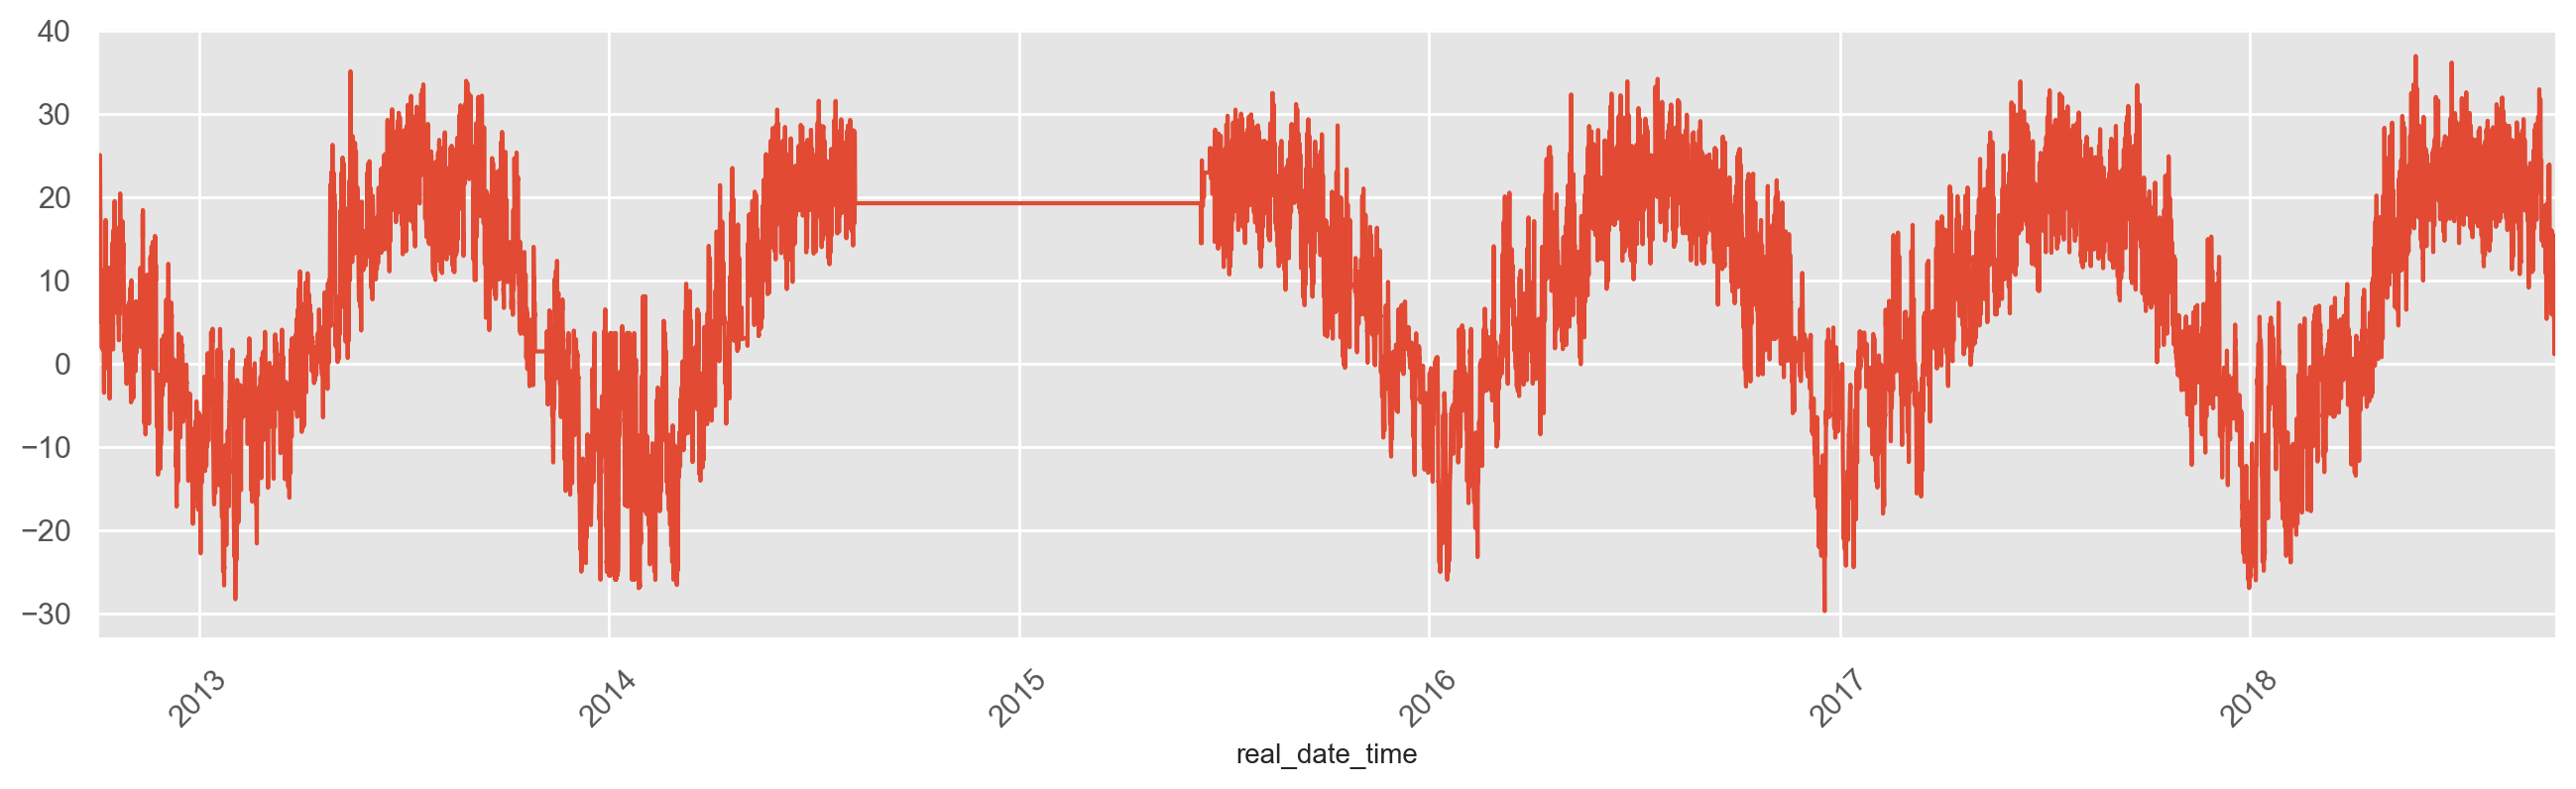

In [29]:
plot_data(df['temp'])

In [30]:
df_temp_1 = df

# Split data

### Keep 2 last week for test

In [31]:
split_date = '2018-09-16'

df = df_temp_1['2018-07-01':'2018-09-30']
df.shape

(2208, 4)

In [32]:
df_train = df.iloc[df.index < split_date].copy()
df_test = df.iloc[df.index > split_date].copy()

In [33]:
print(f"df_train: {df_train.shape}, df_test: {df_test.shape}")

df_train: (1848, 4), df_test: (359, 4)


In [34]:
def plot_data(df):
  plt.figure(figsize=(18,8))
  plt.plot(df_train.traffic_volume)
  plt.plot(df_test.traffic_volume)
  plt.show()

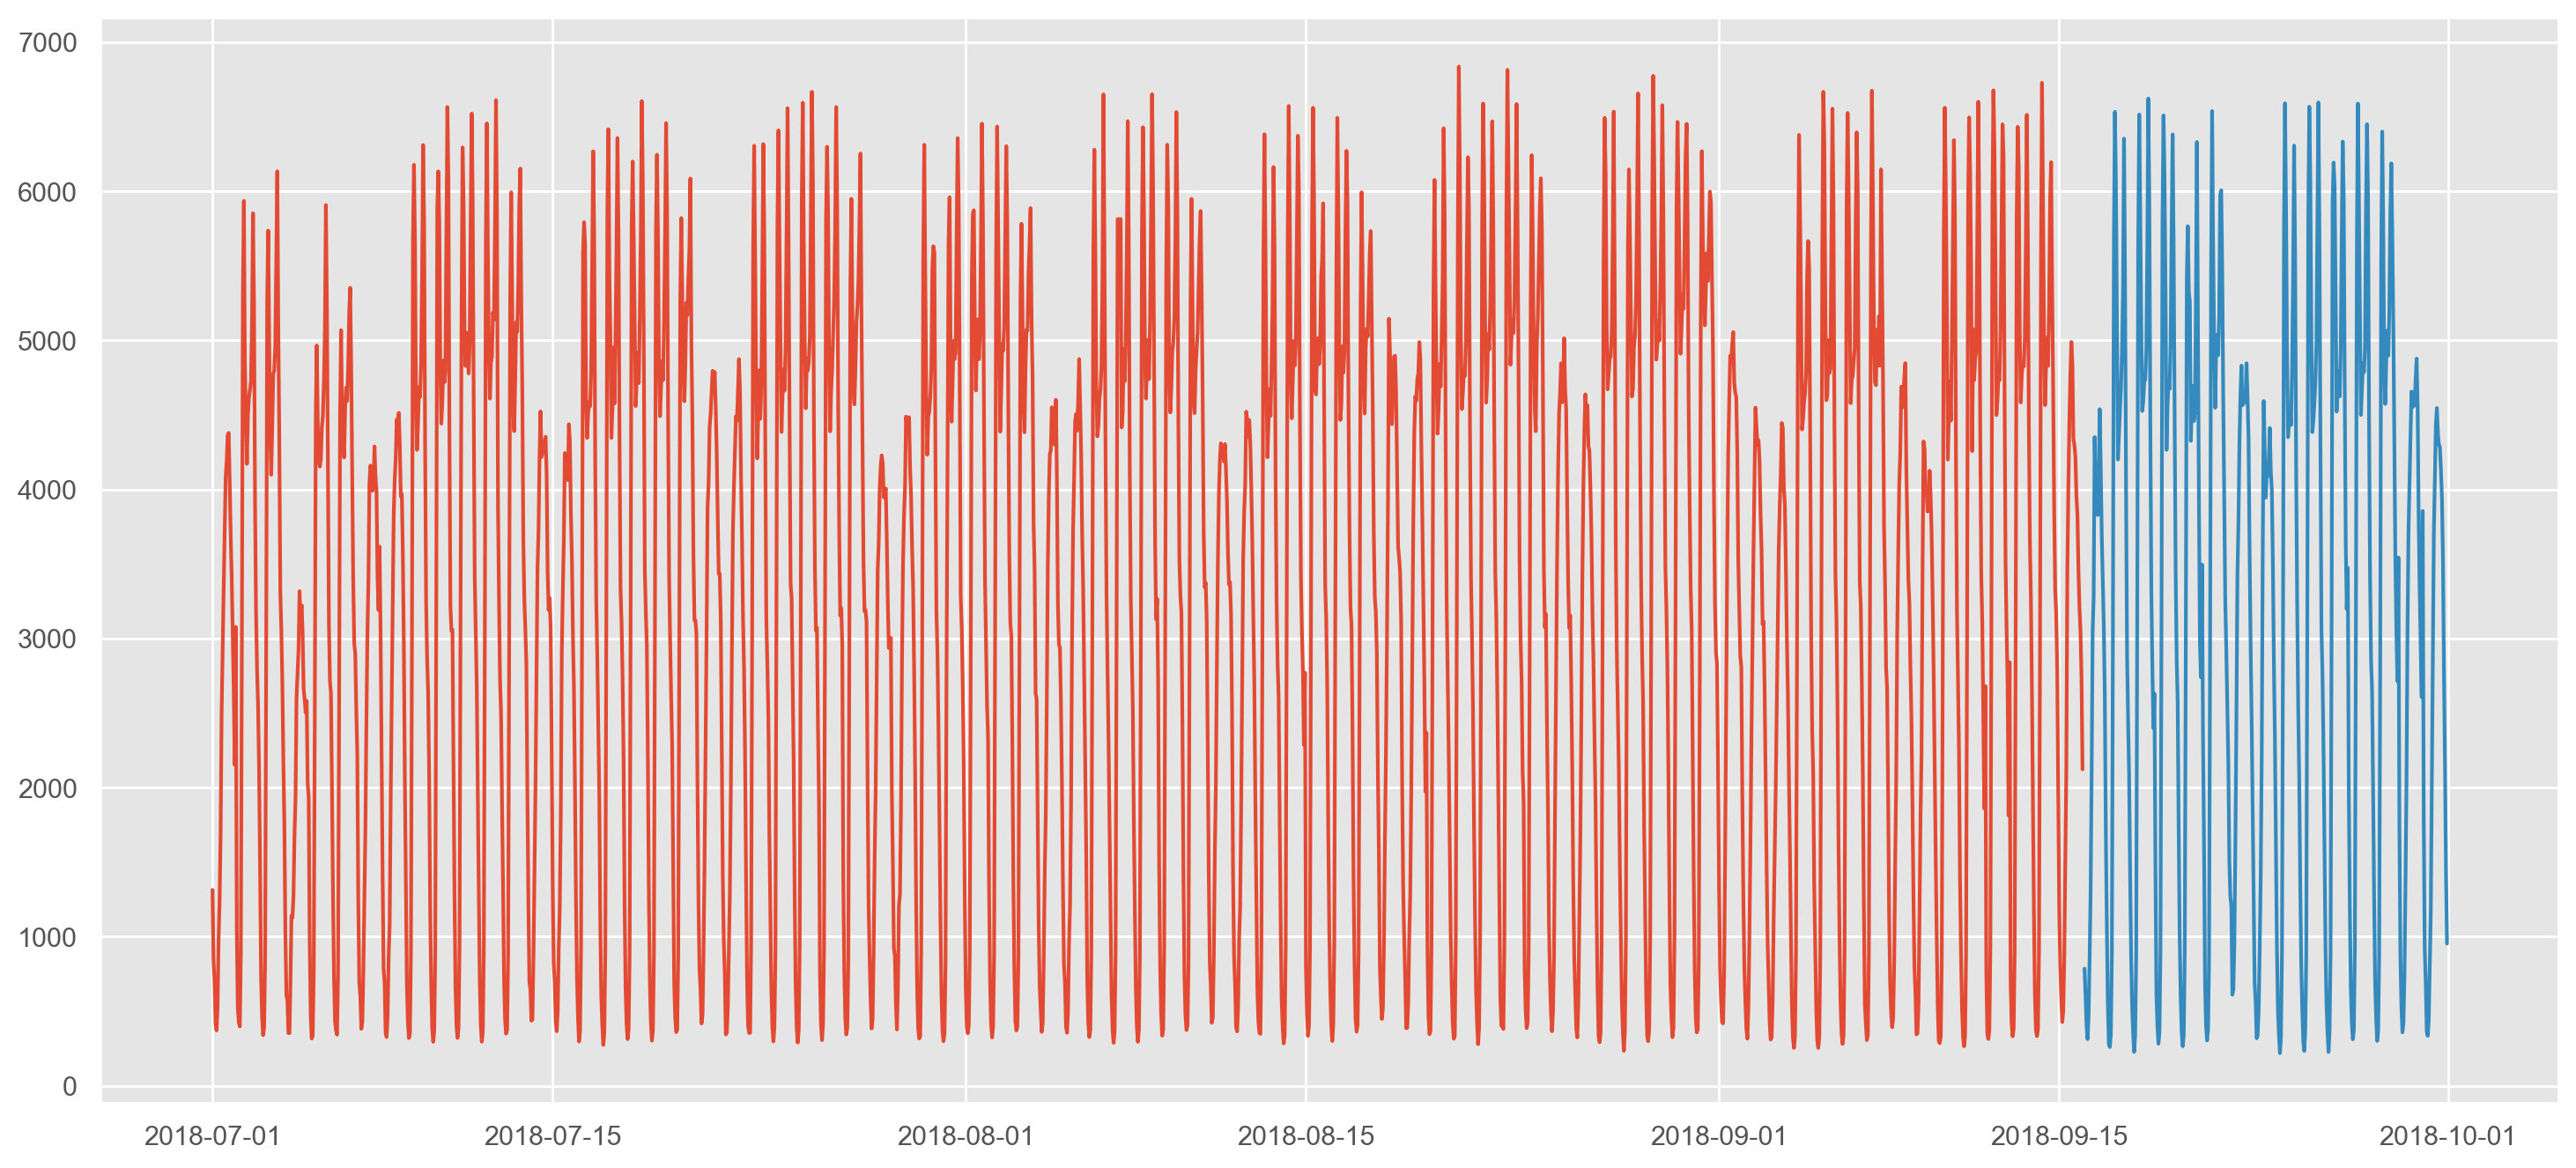

In [35]:
plot_data(df)

# Additional features

In [36]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df["is_weekend"] = df.index.weekday.isin([5,6]).astype(int)
    df["holiday"] = df['holiday']
    df["hour_cos"] = -np.cos(((2 * np.pi * df.index.hour) / 24)) + 1
    df["day_sin"] = np.sin(((2 * np.pi * (df.index.weekday) - 1) / 7)) + 1
    df["month_cos"] = -np.cos(((2 * np.pi * (df.index.month) / 12))) + 1

    X = df[['hour_cos','day_sin','month_cos','hour','day_of_week','quarter','month','year','day_of_year','day_of_month','week_of_year', 'is_weekend','holiday']]
    
    if label:
        y = df[label]
        return X, y
    return X

In [37]:
# def mean_absolute_percentage_error(y_true, y_pred):   
#   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [38]:
def error_metrics(y_true, y_pred):  
  print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
  print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  print('Mean Absolute Percentage Error: {:.2f} %'.format(mape))

# Baseline forecast

In [39]:
new_features_train = create_features(df_train)
new_features_test = create_features(df_test)

In [40]:
new_features_train.head()

hour_cos  day_sin  month_cos  hour  day_of_week  quarter  \
real_date_time                                                                  
2018-07-01 00:00:00    0.0000   0.1374      1.866     0            6        3   
2018-07-01 01:00:00    0.0341   0.1374      1.866     1            6        3   
2018-07-01 02:00:00    0.1340   0.1374      1.866     2            6        3   
2018-07-01 03:00:00    0.2929   0.1374      1.866     3            6        3   
2018-07-01 04:00:00    0.5000   0.1374      1.866     4            6        3   

                     month  year  day_of_year  day_of_month  week_of_year  \
real_date_time                                                              
2018-07-01 00:00:00      7  2018          182             1            26   
2018-07-01 01:00:00      7  2018          182             1            26   
2018-07-01 02:00:00      7  2018          182             1            26   
2018-07-01 03:00:00      7  2018          182             1            26   
2018-07-01 04:00:00      7  2018          182             1            26   

                     is_weekend  holiday  
real_date_time                            
2018-07-01 00:00:00           1      0.0  
2018-07-01 01:00:00           1      0.0  
2018-07-01 02:00:00           1      0.0  
2018-07-01 03:00:00           1      0.0  
2018-07-01 04:00:00           1      0.0

In [41]:
df_groupby_train = df_train.groupby(["day_of_week", "hour"])["traffic_volume"].mean()

In [42]:
df_groupby_test = df_test.groupby(["day_of_week", "hour"])["traffic_volume"].mean()

In [43]:
error_metrics(df_groupby_train, df_groupby_test)

Mean Absolute Error: 176.50
Root Mean Squared Error: 244.88
Mean Absolute Percentage Error: 7.60 %


In [44]:
X_train, y_train = create_features(df_train, label='traffic_volume')
X_test, y_test = create_features(df_test, label='traffic_volume')

In [45]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1848, 13), (359, 13), (1848,), (359,))

# LinearRegression

In [46]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [47]:
%%time
y_pred = lr.predict(X_test)

CPU times: user 5.31 ms, sys: 2.08 ms, total: 7.38 ms
Wall time: 2.69 ms


In [48]:
def plot_predictions(y_pred):
  plt.figure(figsize=(15,6))
  plt.plot(df_test.index, pd.DataFrame(df_test.traffic_volume), marker='.', label="actual")
  plt.plot(df_test.index, y_pred, 'r', label="prediction")
  plt.ylabel('Traffic Volume', size=15)
  plt.xlabel('Date', size=15)
  plt.legend(fontsize=13)
  plt.show()

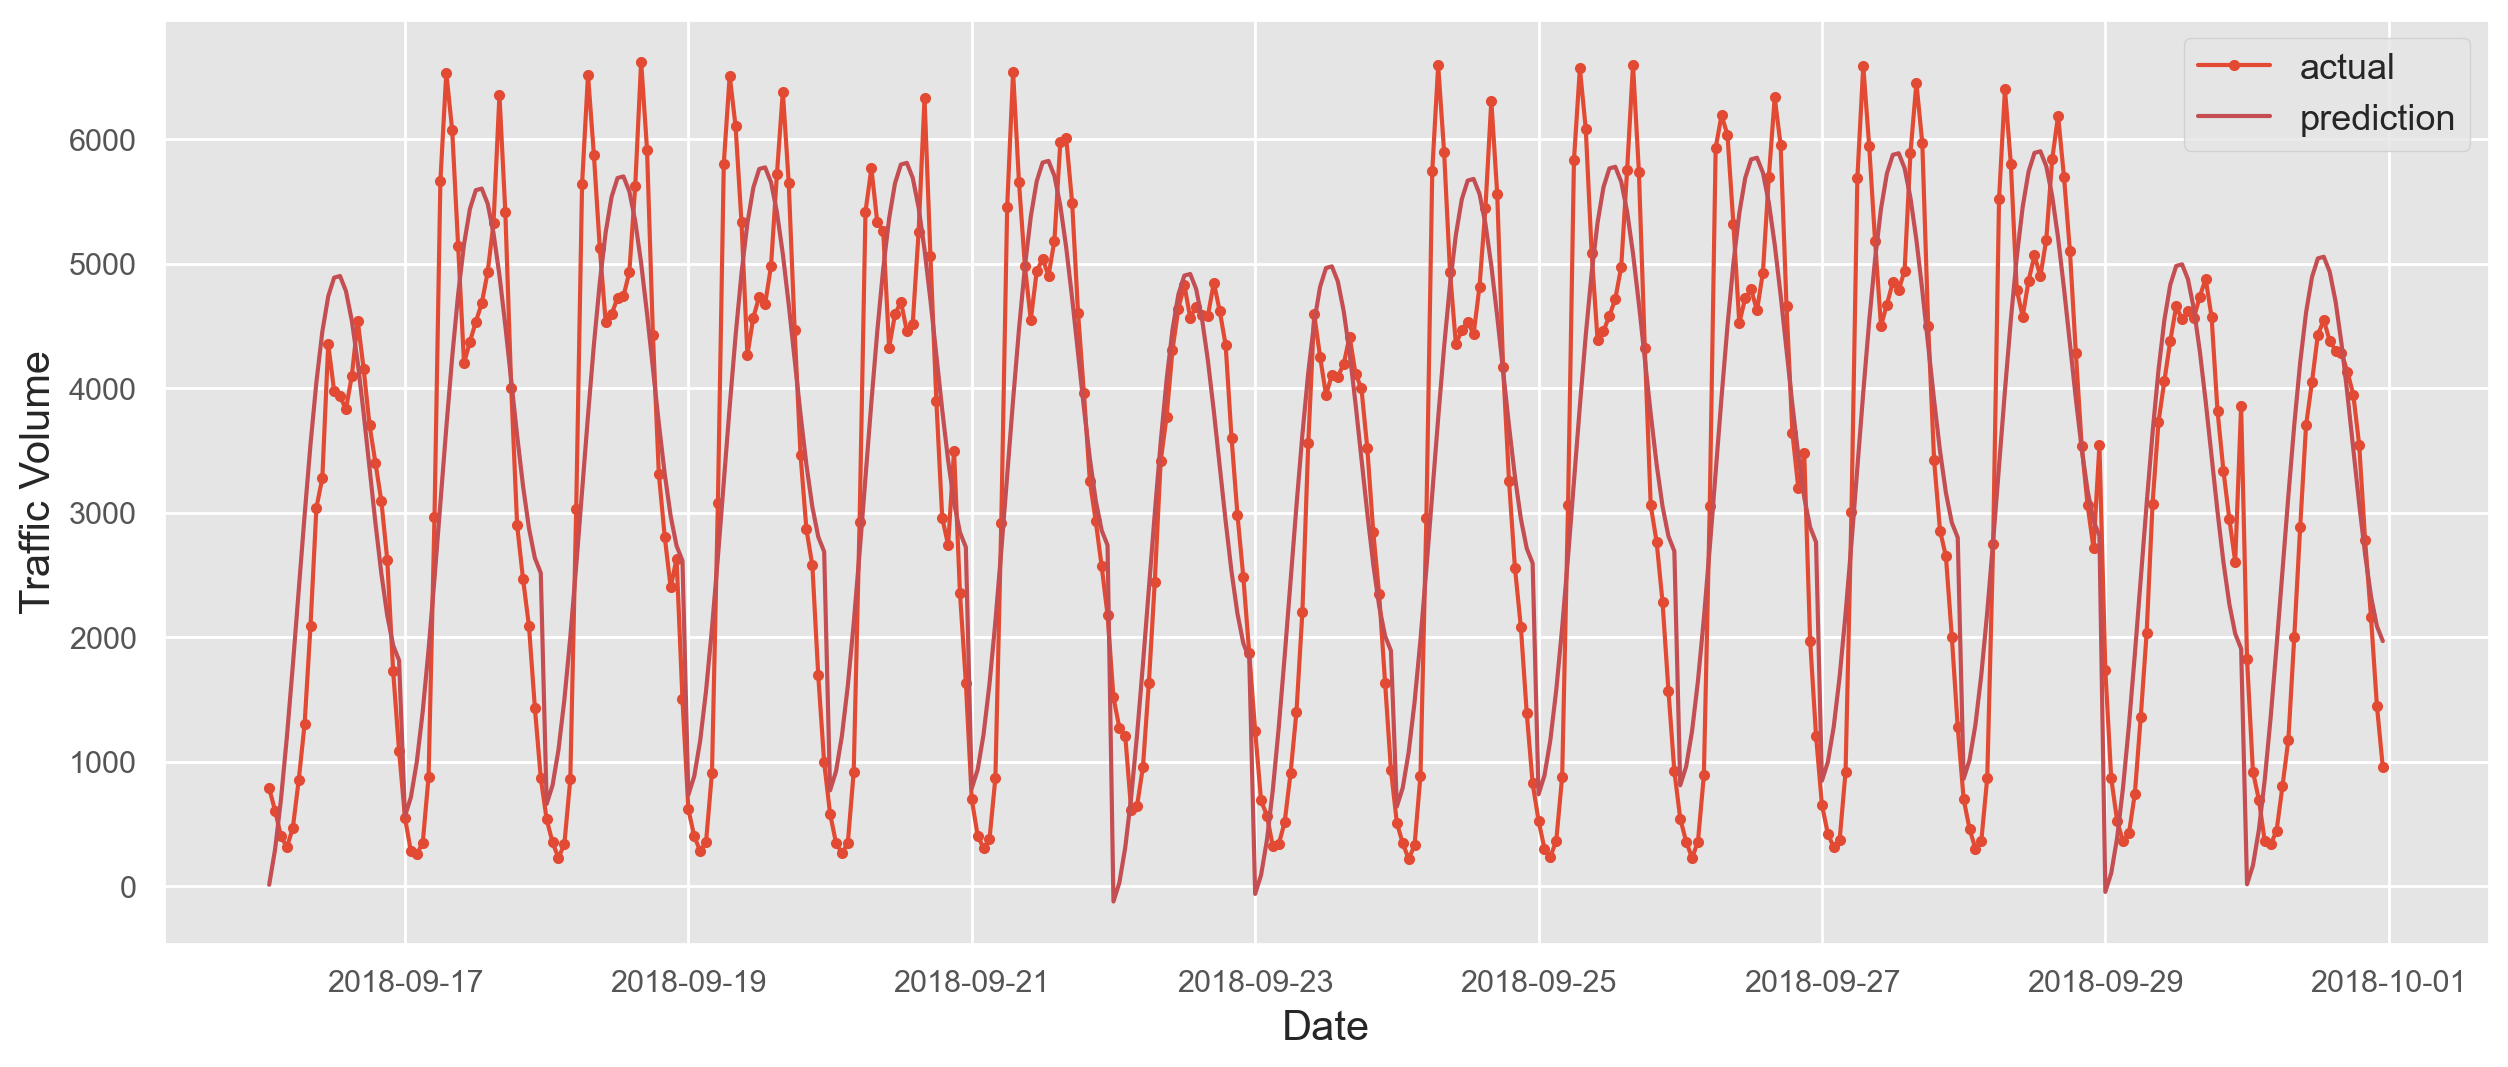

In [49]:
plot_predictions(y_pred)

In [50]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 854.03
Root Mean Squared Error: 1043.87
Mean Absolute Percentage Error: 60.03 %


In [51]:
def plotCoefficients(model, X_train):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(8, 5))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

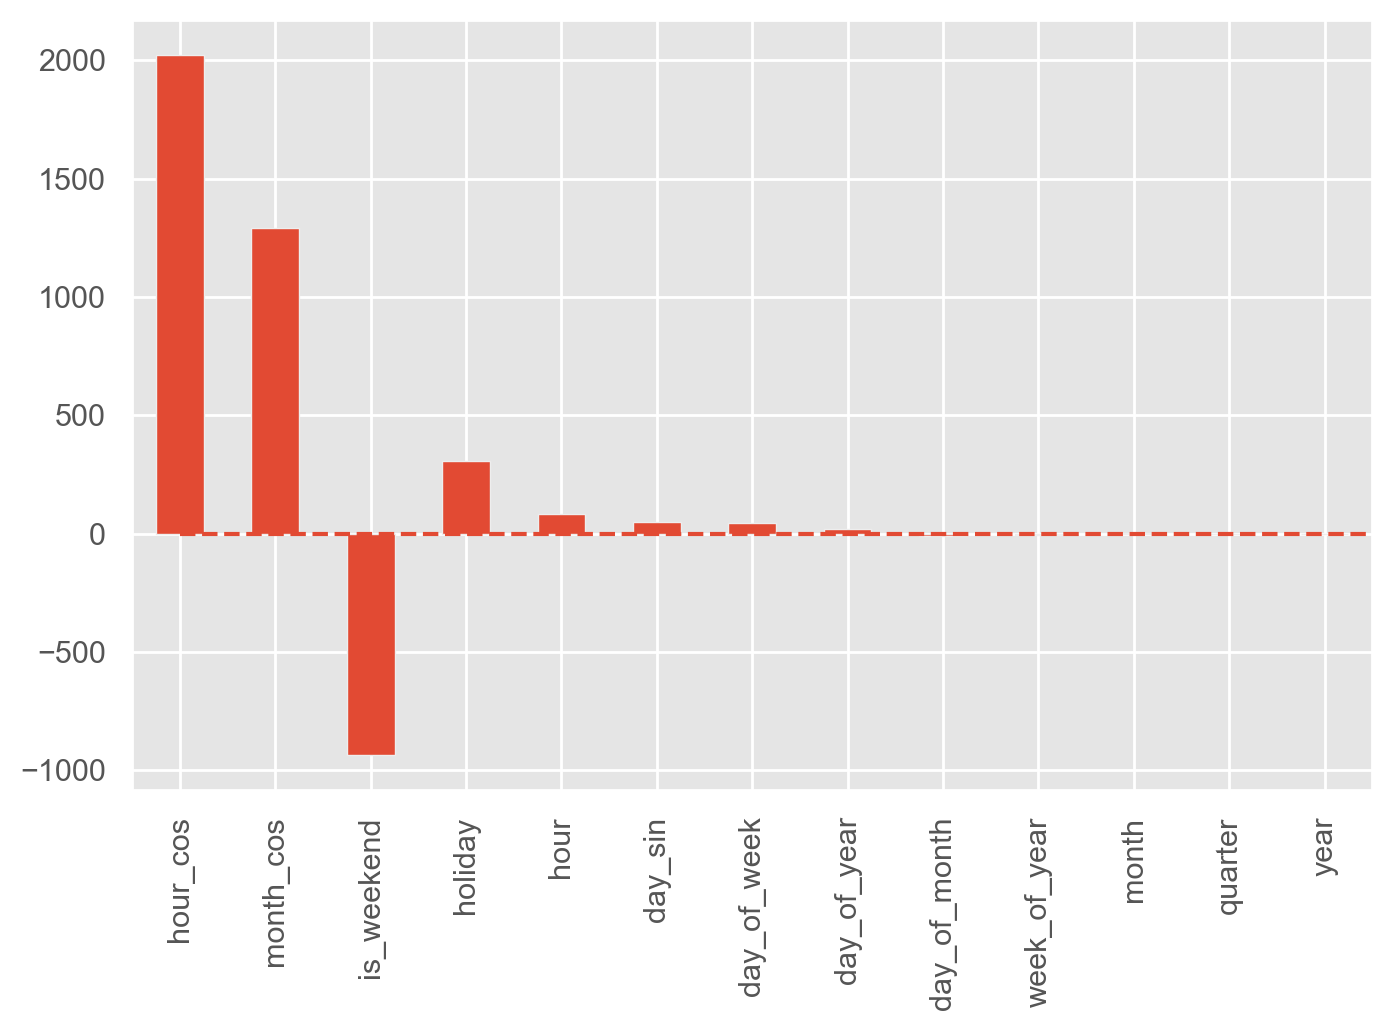

In [52]:
plotCoefficients(lr, X_train)

# Lasso

In [53]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)

lasso = LassoCV(cv=tscv, eps=0.001)
lasso.fit(X_train, y_train)

LassoCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None))

In [54]:
%%time
y_pred = lasso.predict(X_test)

CPU times: user 5.61 ms, sys: 3.02 ms, total: 8.63 ms
Wall time: 2.08 ms


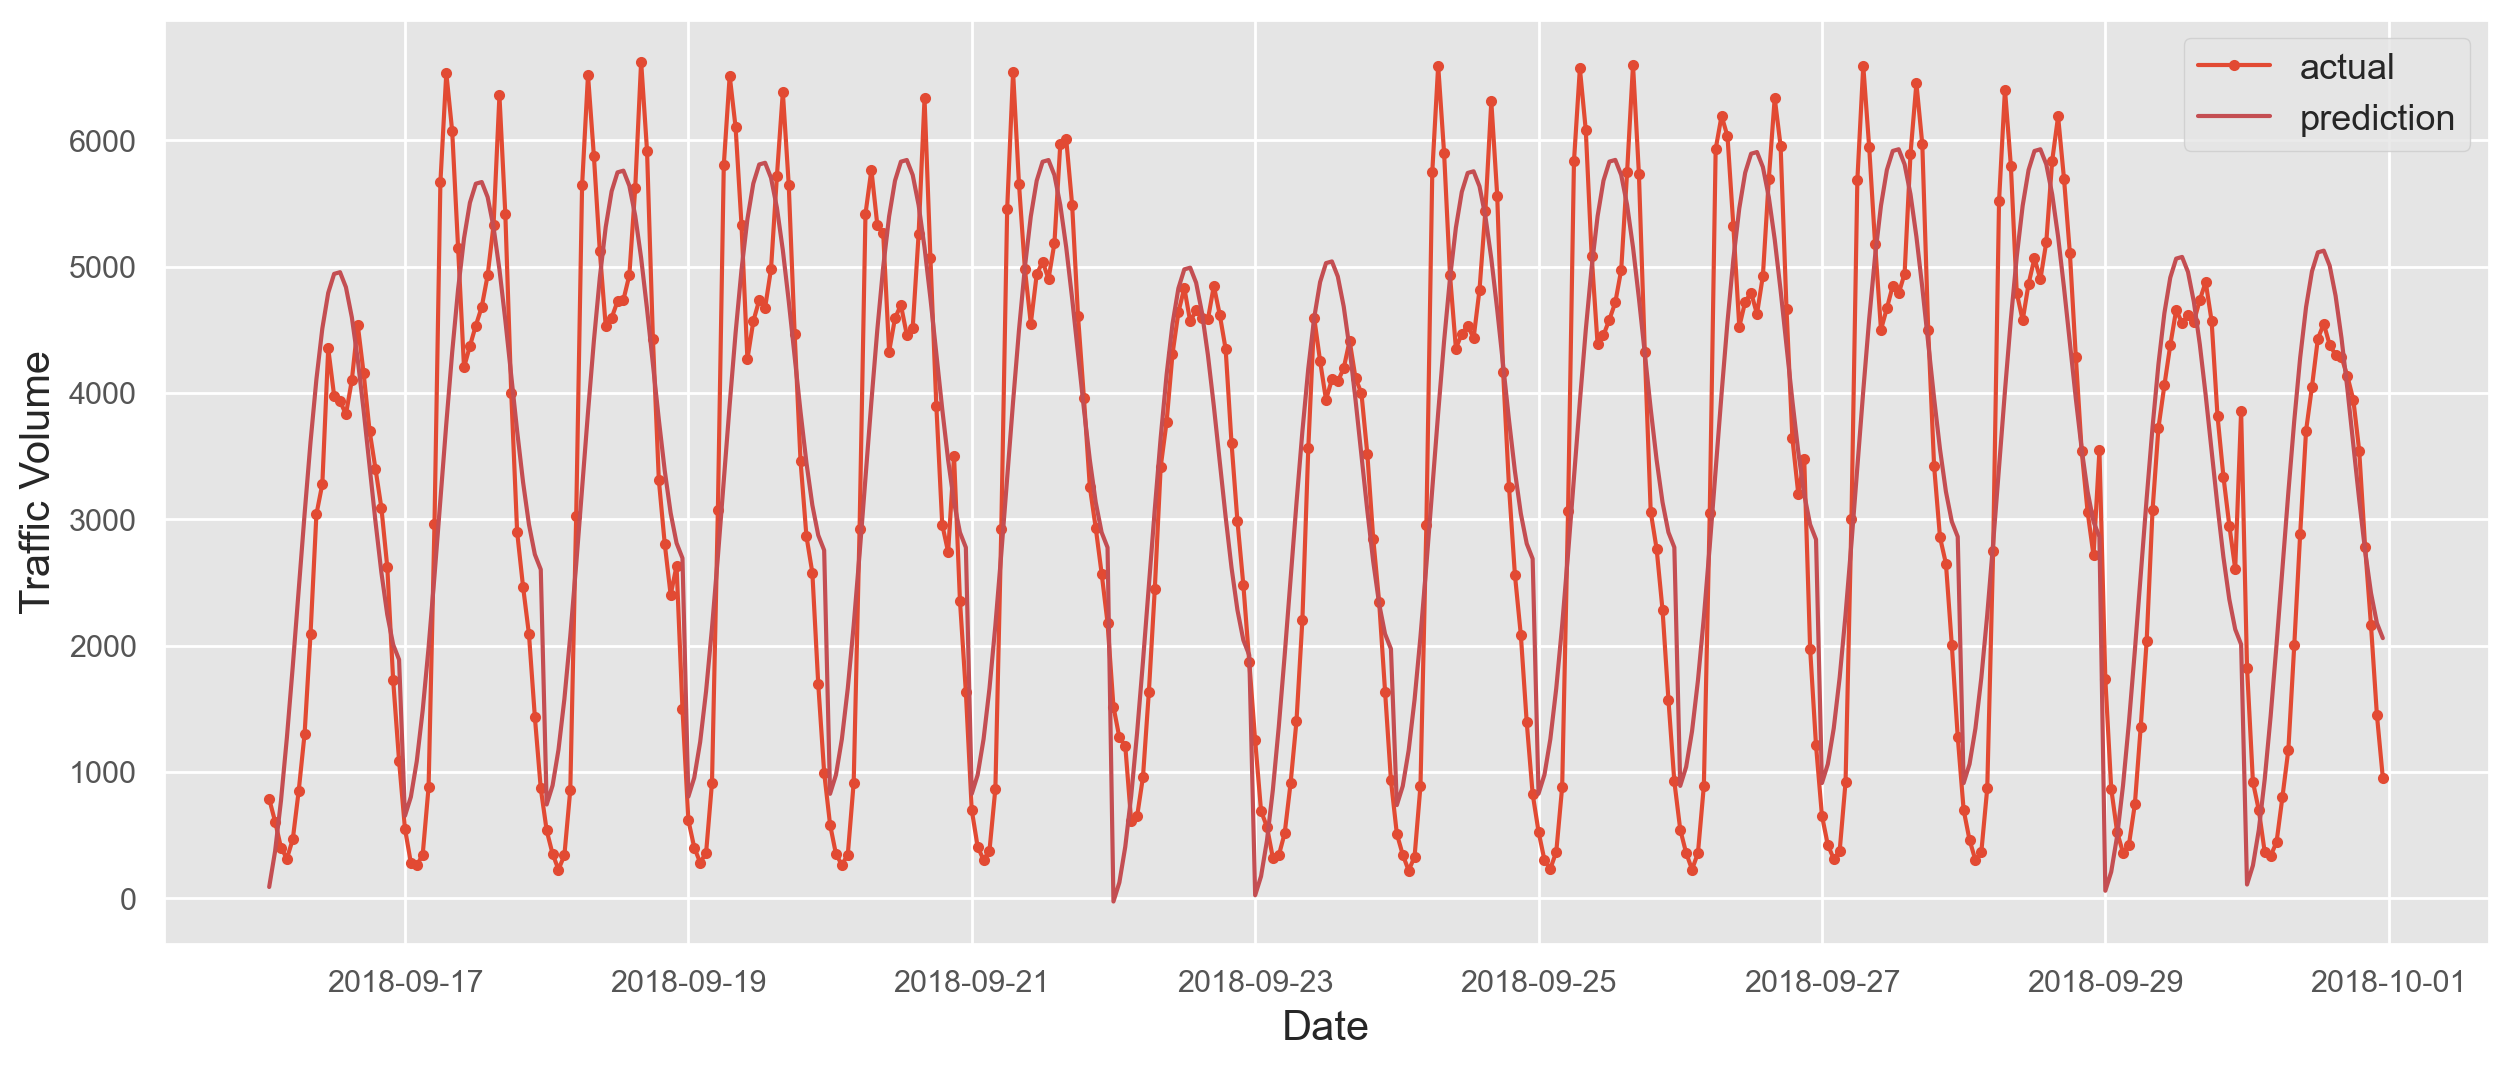

In [55]:
plot_predictions(y_pred)

In [56]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 870.09
Root Mean Squared Error: 1054.23
Mean Absolute Percentage Error: 63.51 %


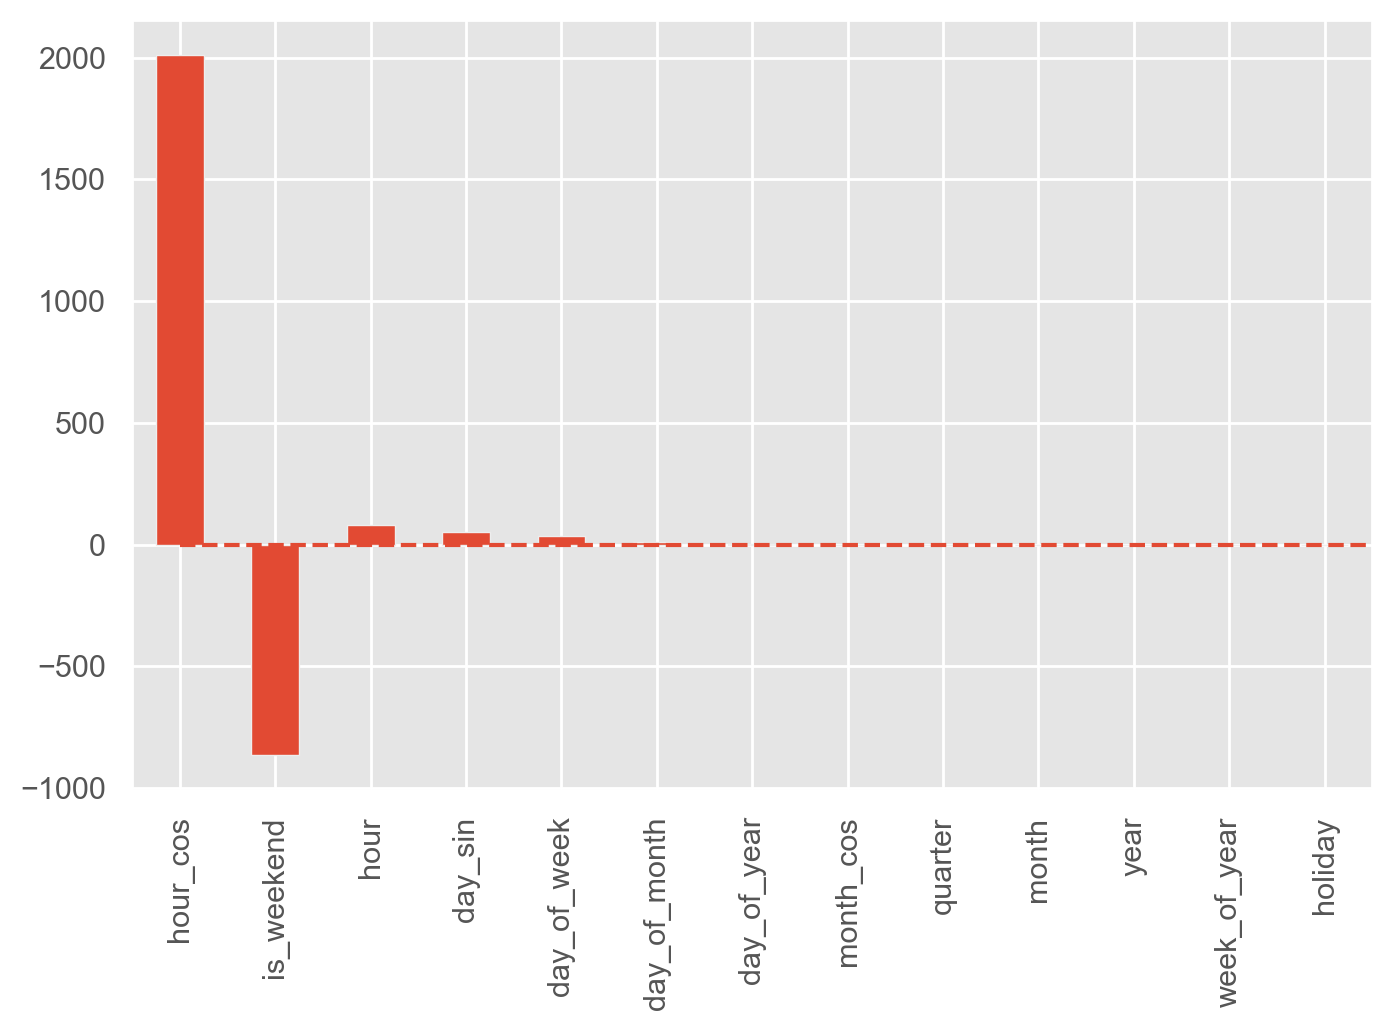

In [57]:
plotCoefficients(lasso, X_train)

# RandomForestClassifier

In [58]:
rf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=500, random_state=42)

In [59]:
y_pred = rf.predict(X_test)

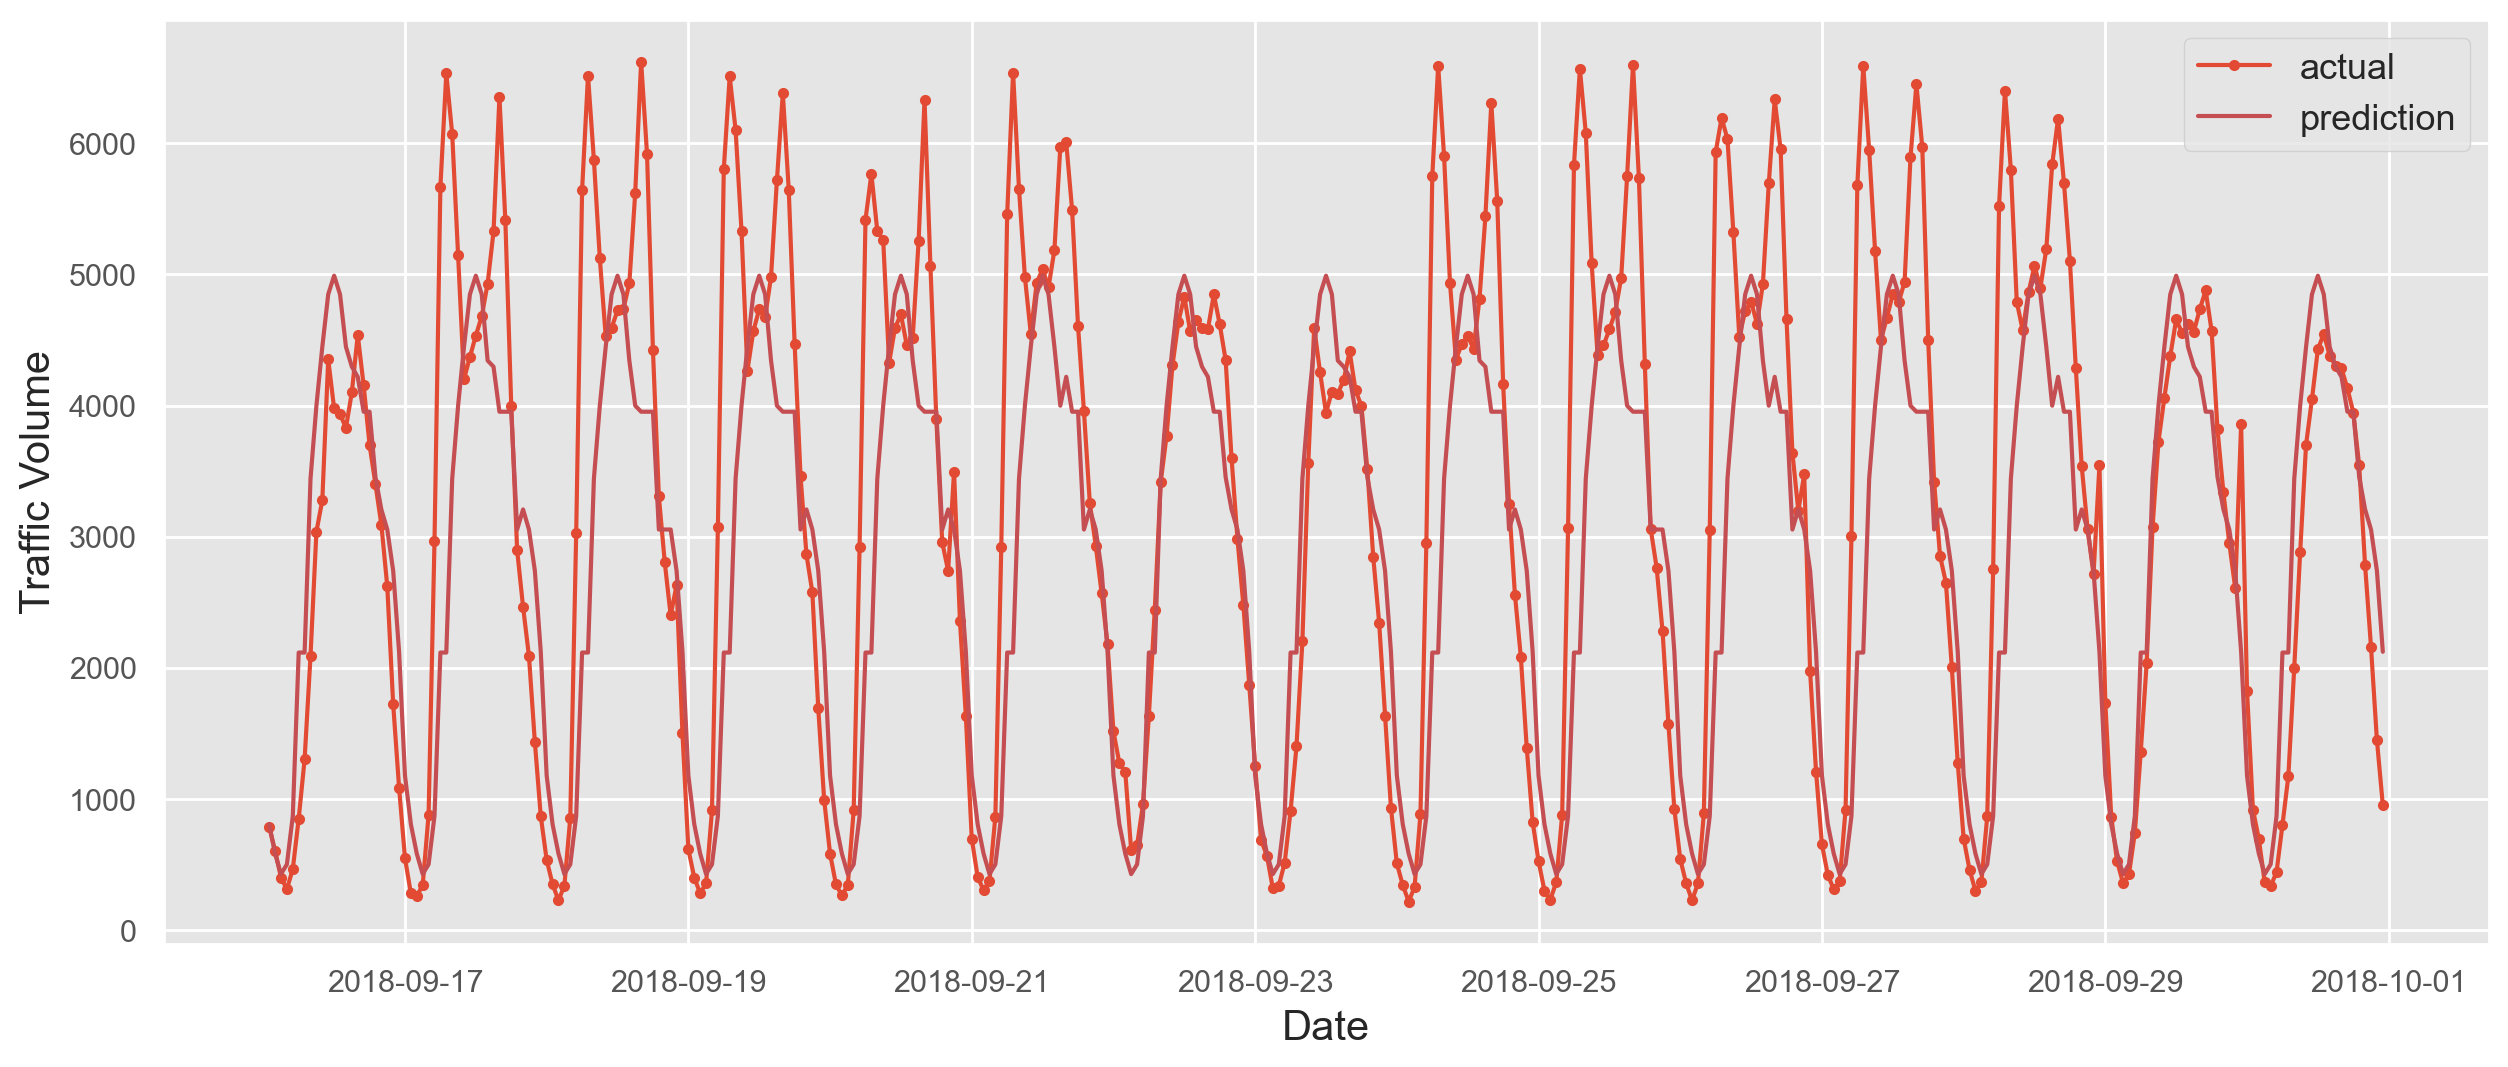

In [60]:
plot_predictions(y_pred)

In [61]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 865.74
Root Mean Squared Error: 1320.85
Mean Absolute Percentage Error: 36.07 %


# GradientBoostingRegressor

In [62]:
%time
gb = GradientBoostingRegressor(n_estimators=500)
gb.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


GradientBoostingRegressor(n_estimators=500)

In [63]:
y_pred = gb.predict(X_test)

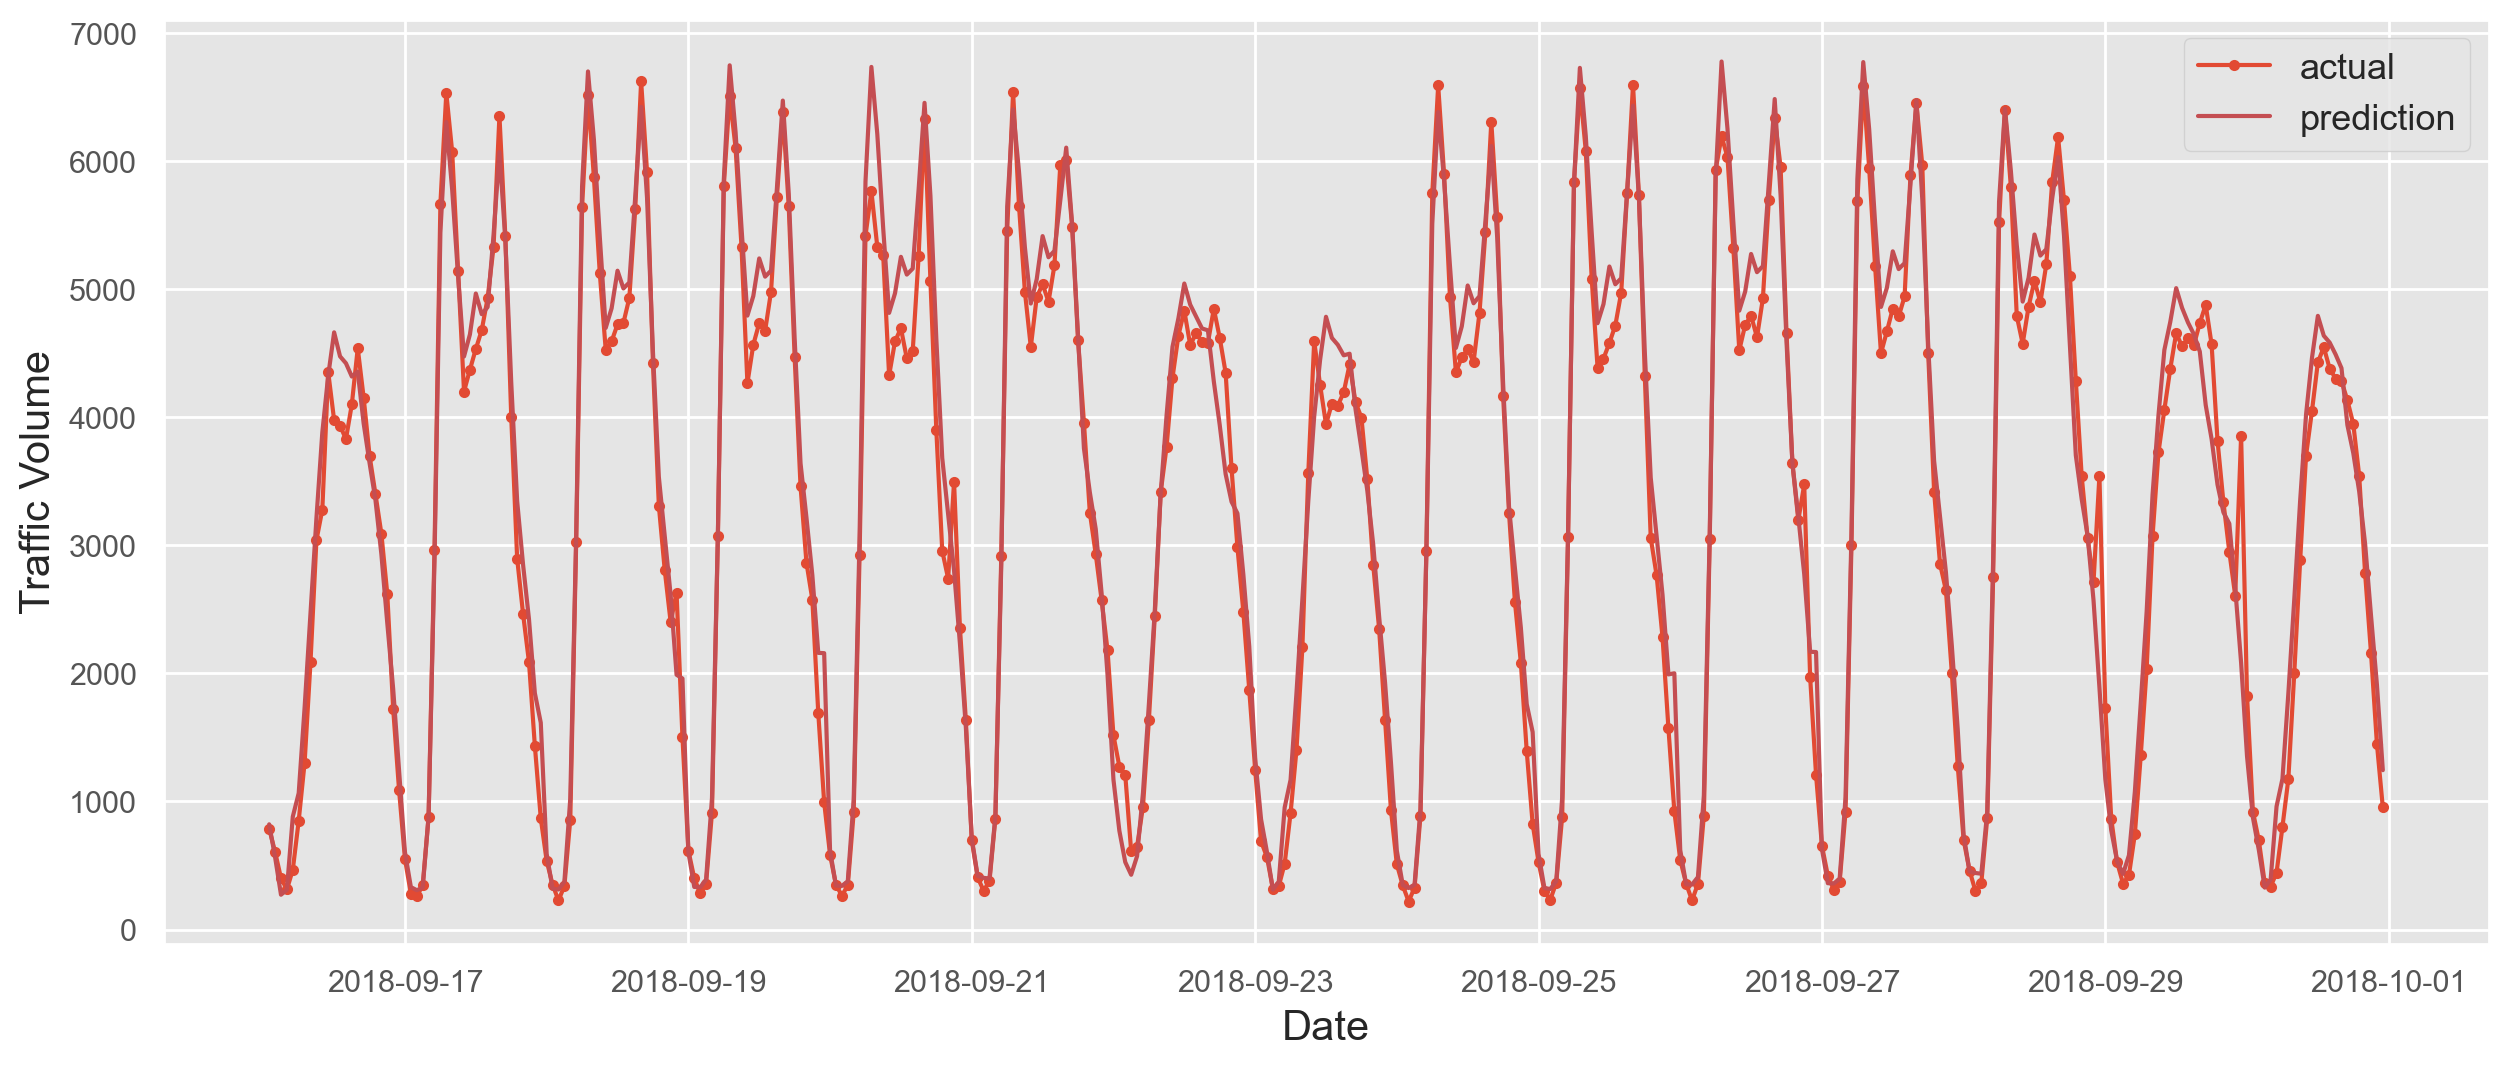

In [64]:
plot_predictions(y_pred)

In [65]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 253.42
Root Mean Squared Error: 345.65
Mean Absolute Percentage Error: 11.98 %


# XGBRegressor

In [66]:
%%time
reg = xgb.XGBRegressor(n_estimators=500)
reg.fit(X_train, y_train)

CPU times: user 2.37 s, sys: 157 ms, total: 2.53 s
Wall time: 355 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [67]:
y_pred = reg.predict(X_test)

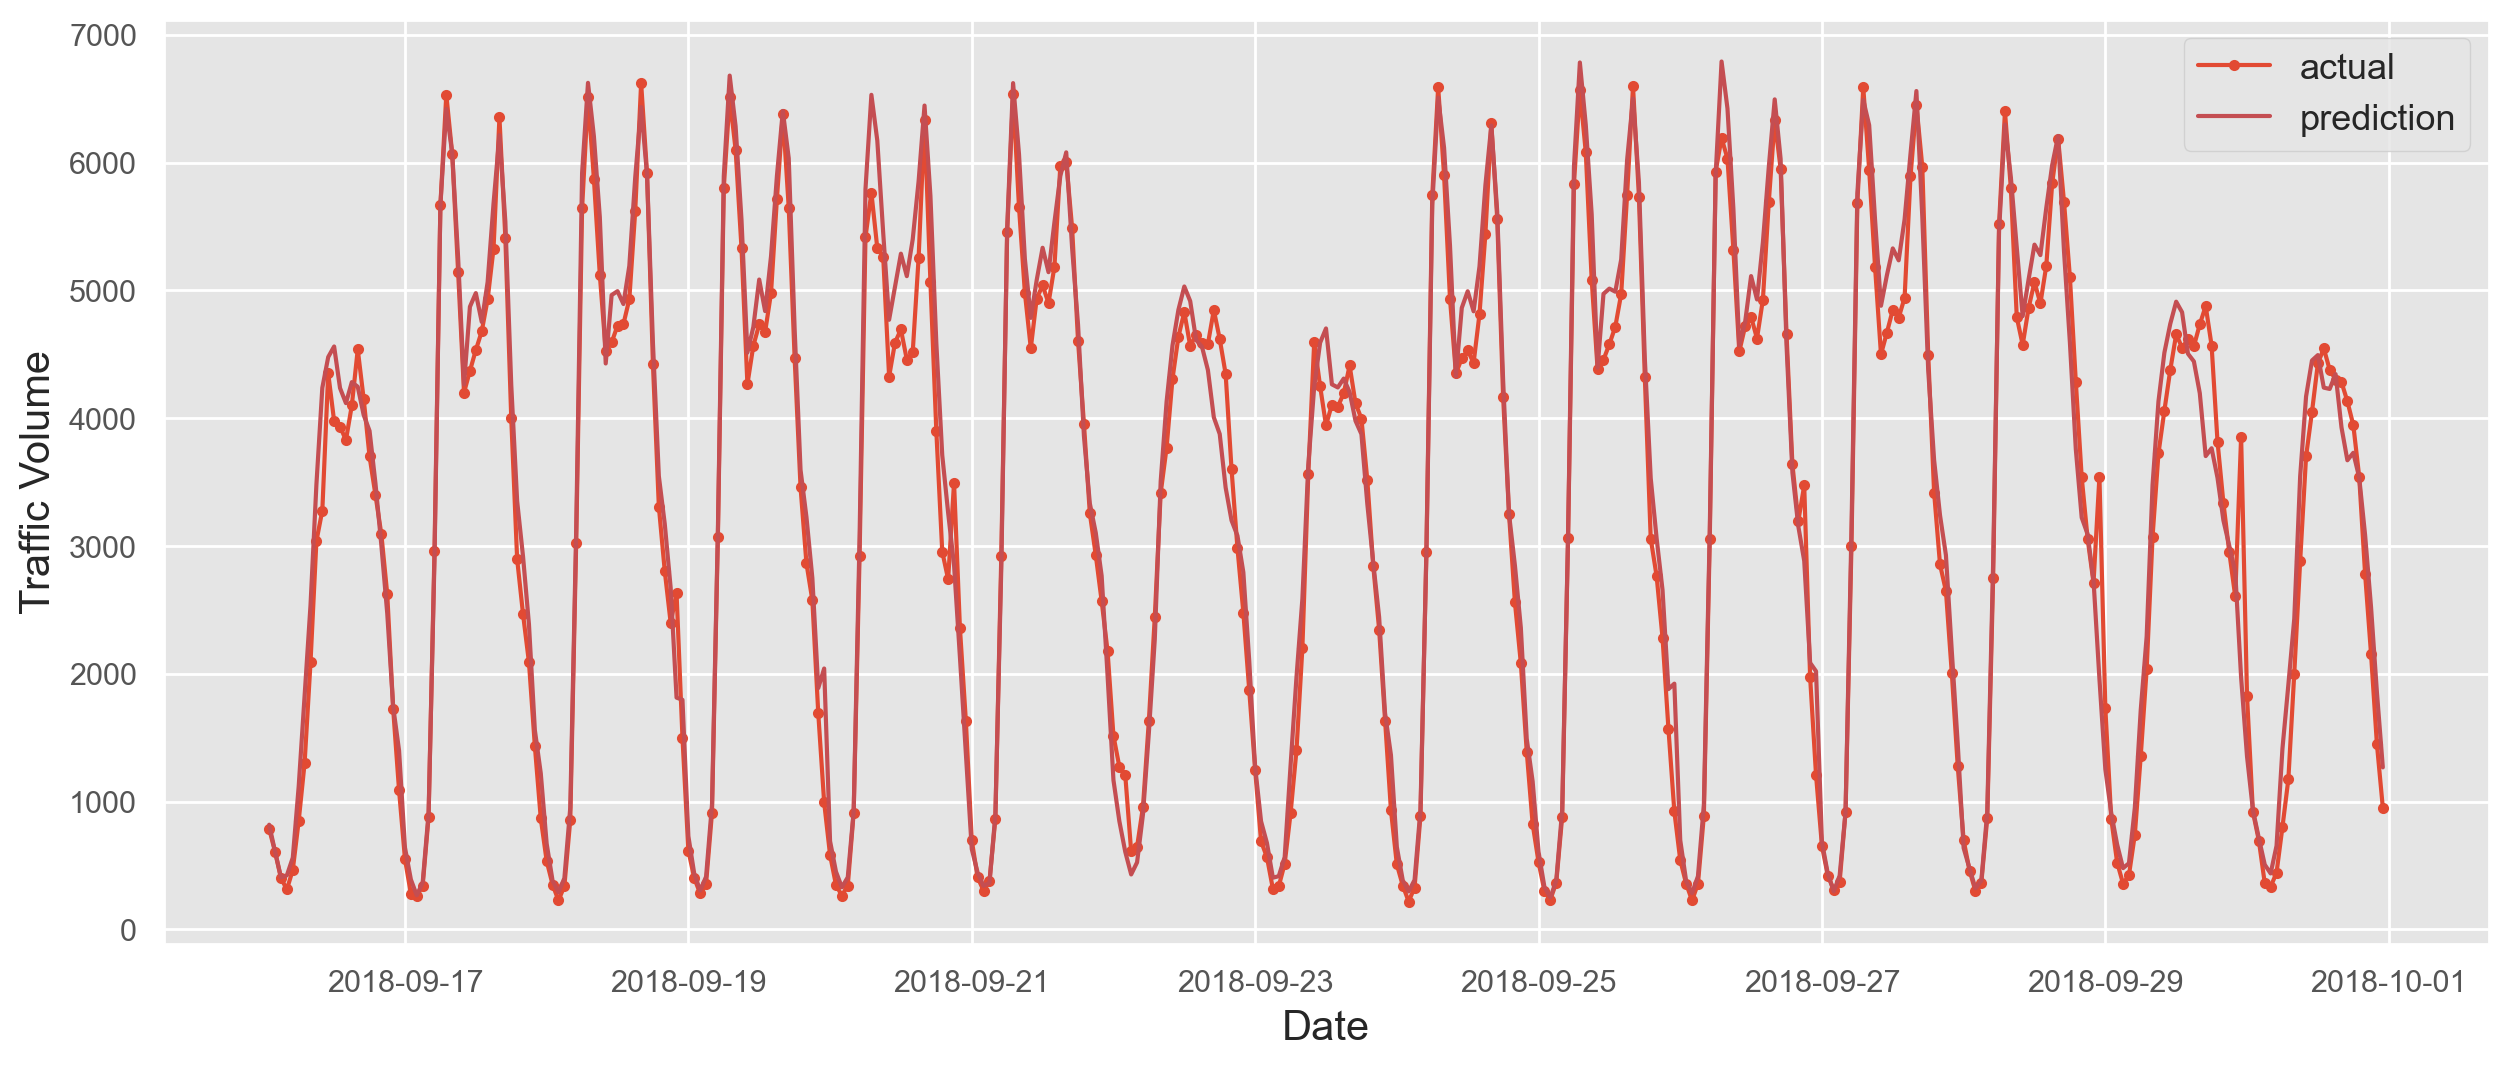

In [68]:
plot_predictions(y_pred)

In [69]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 250.67
Root Mean Squared Error: 347.01
Mean Absolute Percentage Error: 11.16 %


# Prophet

In [70]:
df_fbp = pd.DataFrame()
df_fbp["ds"] = pd.to_datetime(df.index)
df_fbp["y"] = df['traffic_volume'].values

In [71]:
df_fbp.head()

ds       y
0 2018-07-01 00:00:00  1314.0
1 2018-07-01 01:00:00   848.0
2 2018-07-01 02:00:00   703.0
3 2018-07-01 03:00:00   419.0
4 2018-07-01 04:00:00   372.0

In [72]:
df_fbp.shape

(2208, 2)

In [73]:
fb_y_train = df_fbp.iloc[:-300].copy()
fb_y_test = df_fbp.iloc[-300:].copy()
fb_y_val = fb_y_test[["ds"]].copy()

In [74]:
fbmodel = Prophet()
fbmodel.fit(fb_y_train)

forecast = fbmodel.predict(fb_y_val)

17:11:31 - cmdstanpy - INFO - Chain [1] start processing
17:11:32 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
forecast.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
295 2018-09-30 19:00:00  3335.1324   2261.7032   4322.4414    3311.1051   
296 2018-09-30 20:00:00  3335.0847   1634.7898   3595.5292    3310.8961   
297 2018-09-30 21:00:00  3335.0369   1248.1050   3129.7967    3310.7210   
298 2018-09-30 22:00:00  3334.9892    811.1706   2827.1542    3310.5267   
299 2018-09-30 23:00:00  3334.9415    495.8142   2488.1244    3310.3388   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
295    3362.2142        -18.4248              -18.4248              -18.4248   
296    3362.4002       -683.6175             -683.6175             -683.6175   
297    3362.5862      -1153.7639            -1153.7639            -1153.7639   
298    3362.6833      -1472.4618            -1472.4618            -1472.4618   
299    3362.7577      -1831.5682            -1831.5682            -1831.5682   

         daily  daily_lower  daily_upper    weekly  weekly_lower  \
295   373.8811     373.8811     373.8811 -392.3060     -392.3060   
296  -327.1674    -327.1674    -327.1674 -356.4501     -356.4501   
297  -833.2956    -833.2956    -833.2956 -320.4683     -320.4683   
298 -1187.8971   -1187.8971   -1187.8971 -284.5648     -284.5648   
299 -1582.6319   -1582.6319   -1582.6319 -248.9364     -248.9364   

     weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
295     -392.3060                   0.0                         0.0   
296     -356.4501                   0.0                         0.0   
297     -320.4683                   0.0                         0.0   
298     -284.5648                   0.0                         0.0   
299     -248.9364                   0.0                         0.0   

     multiplicative_terms_upper       yhat  
295                         0.0  3316.7076  
296                         0.0  2651.4672  
297                         0.0  2181.2730  
298                         0.0  1862.5274  
299                         0.0  1503.3732

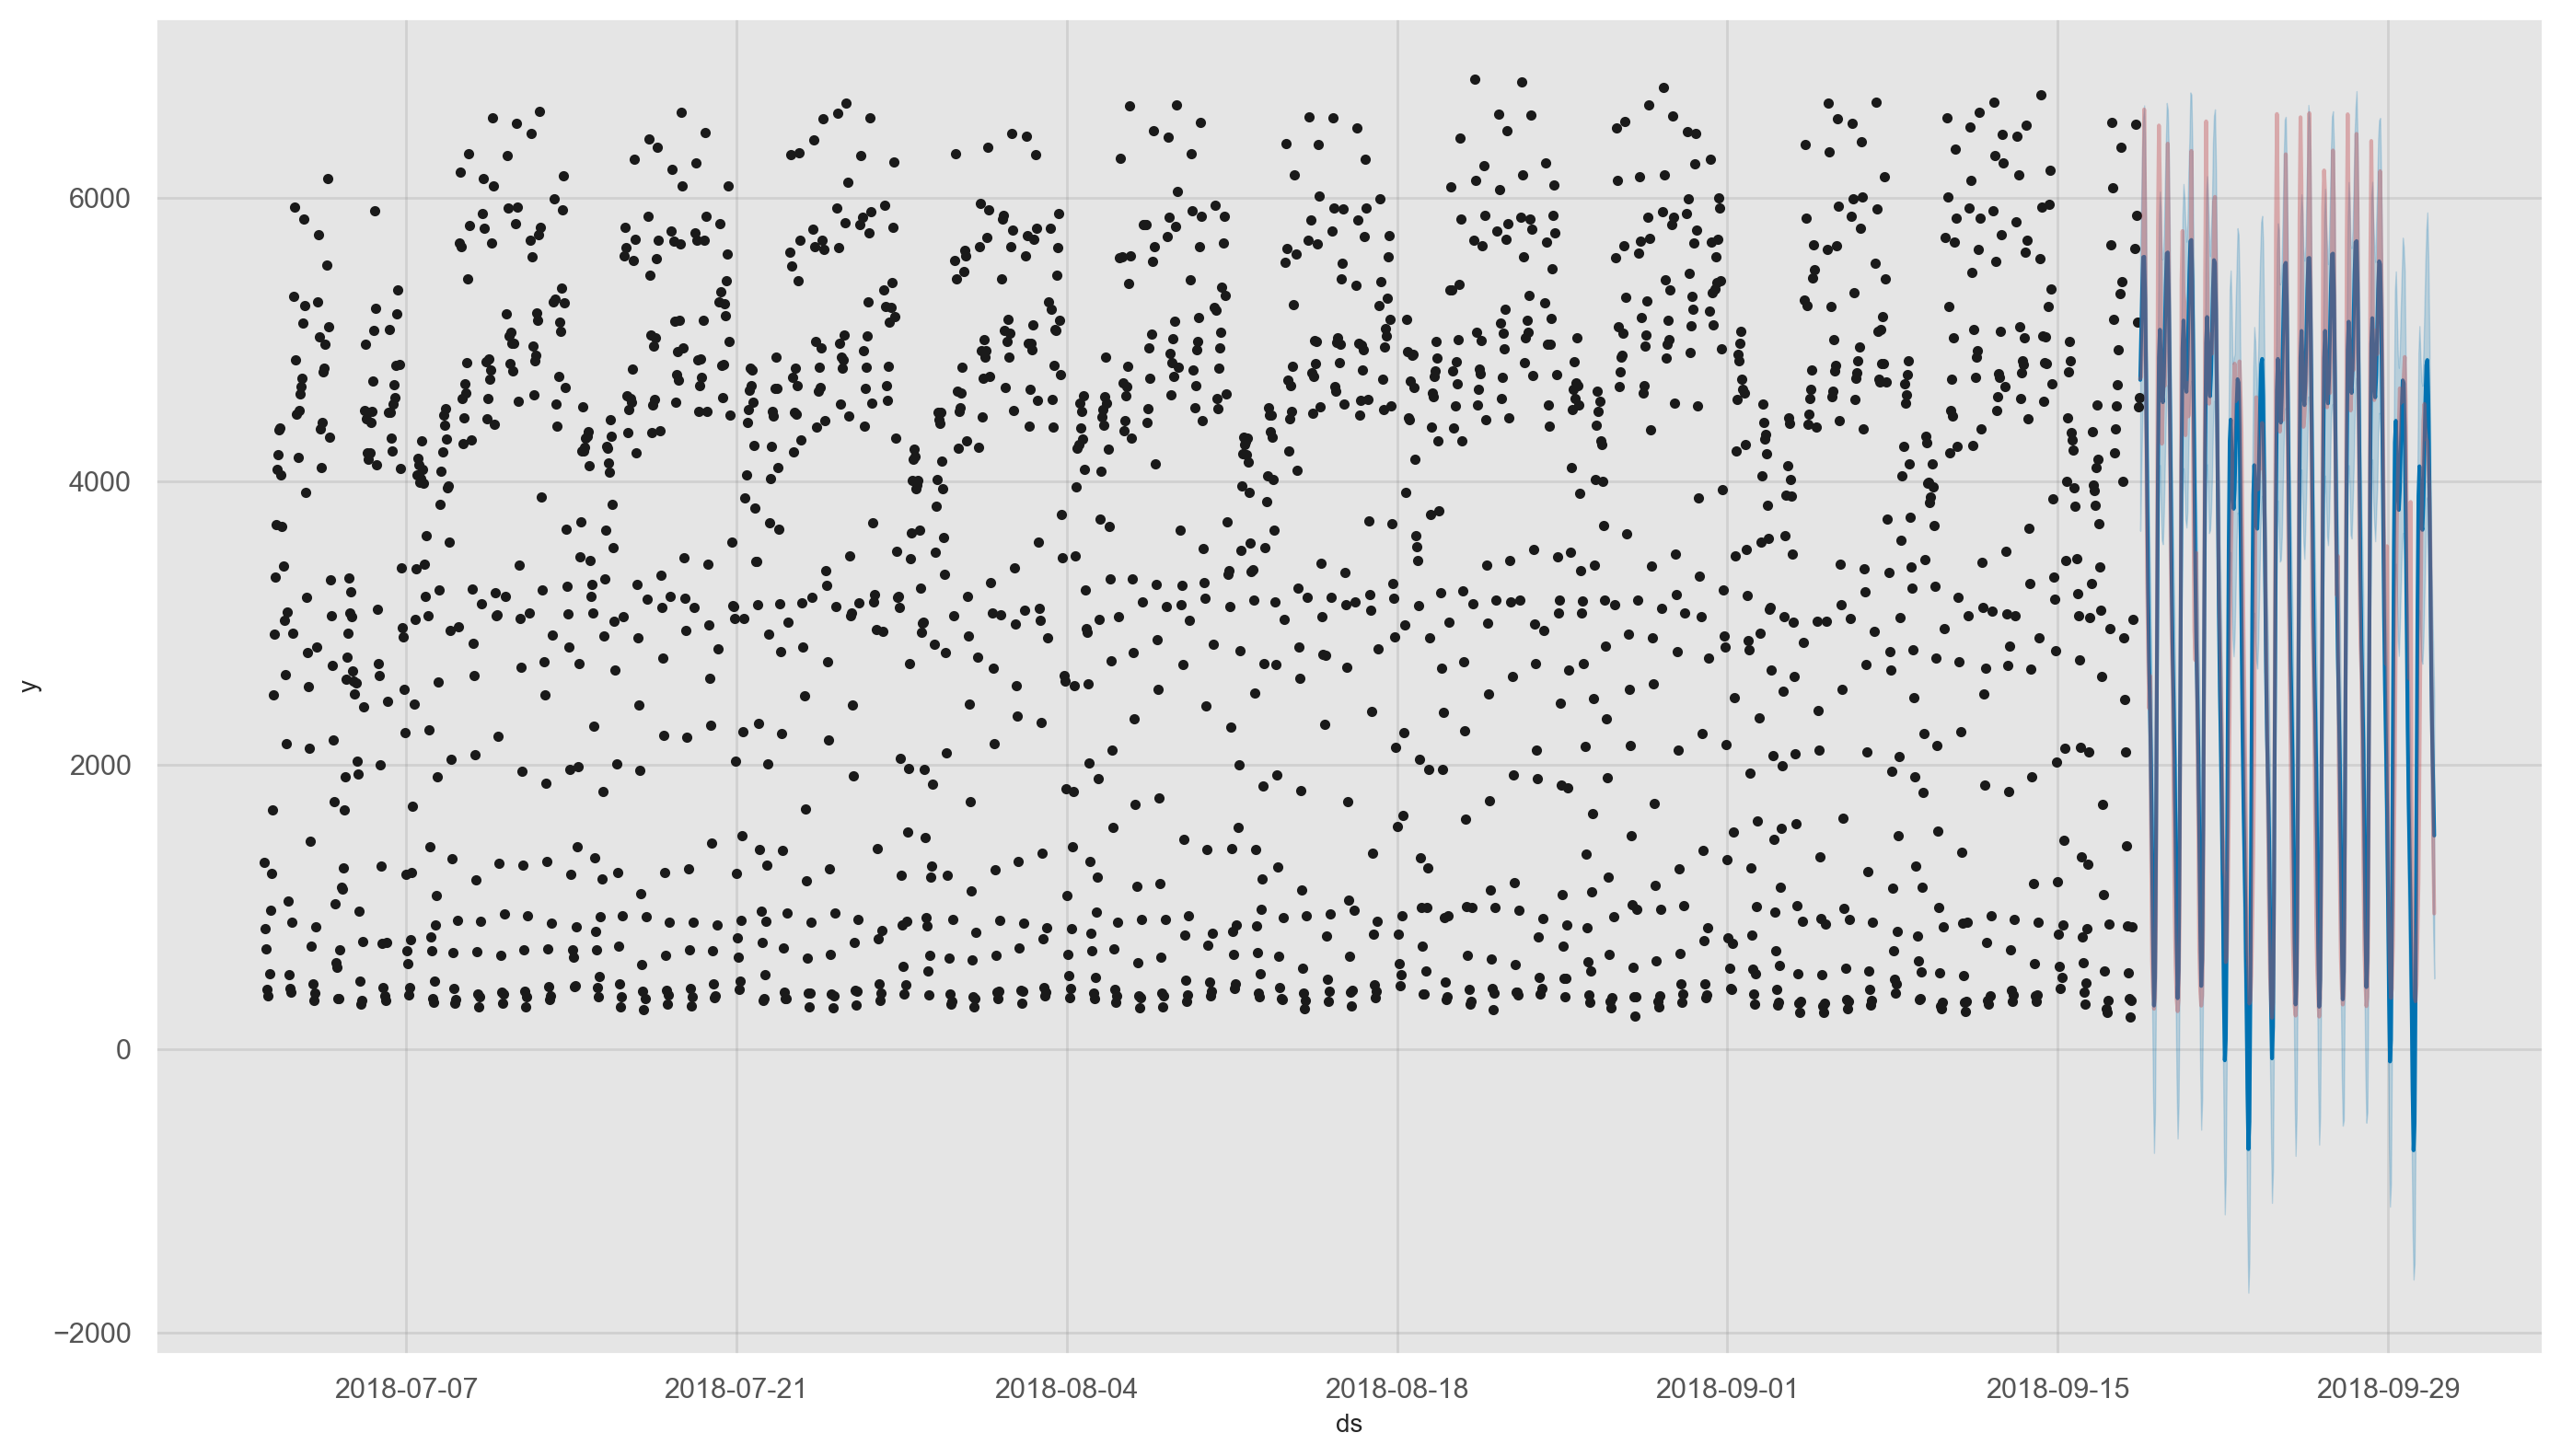

In [76]:
fig2 = fbmodel.plot(forecast, figsize=(14,8))
plt.plot(fb_y_test["ds"], fb_y_test["y"], c="r", alpha=0.4)
plt.show()

In [77]:
plot_plotly(fbmodel, forecast)

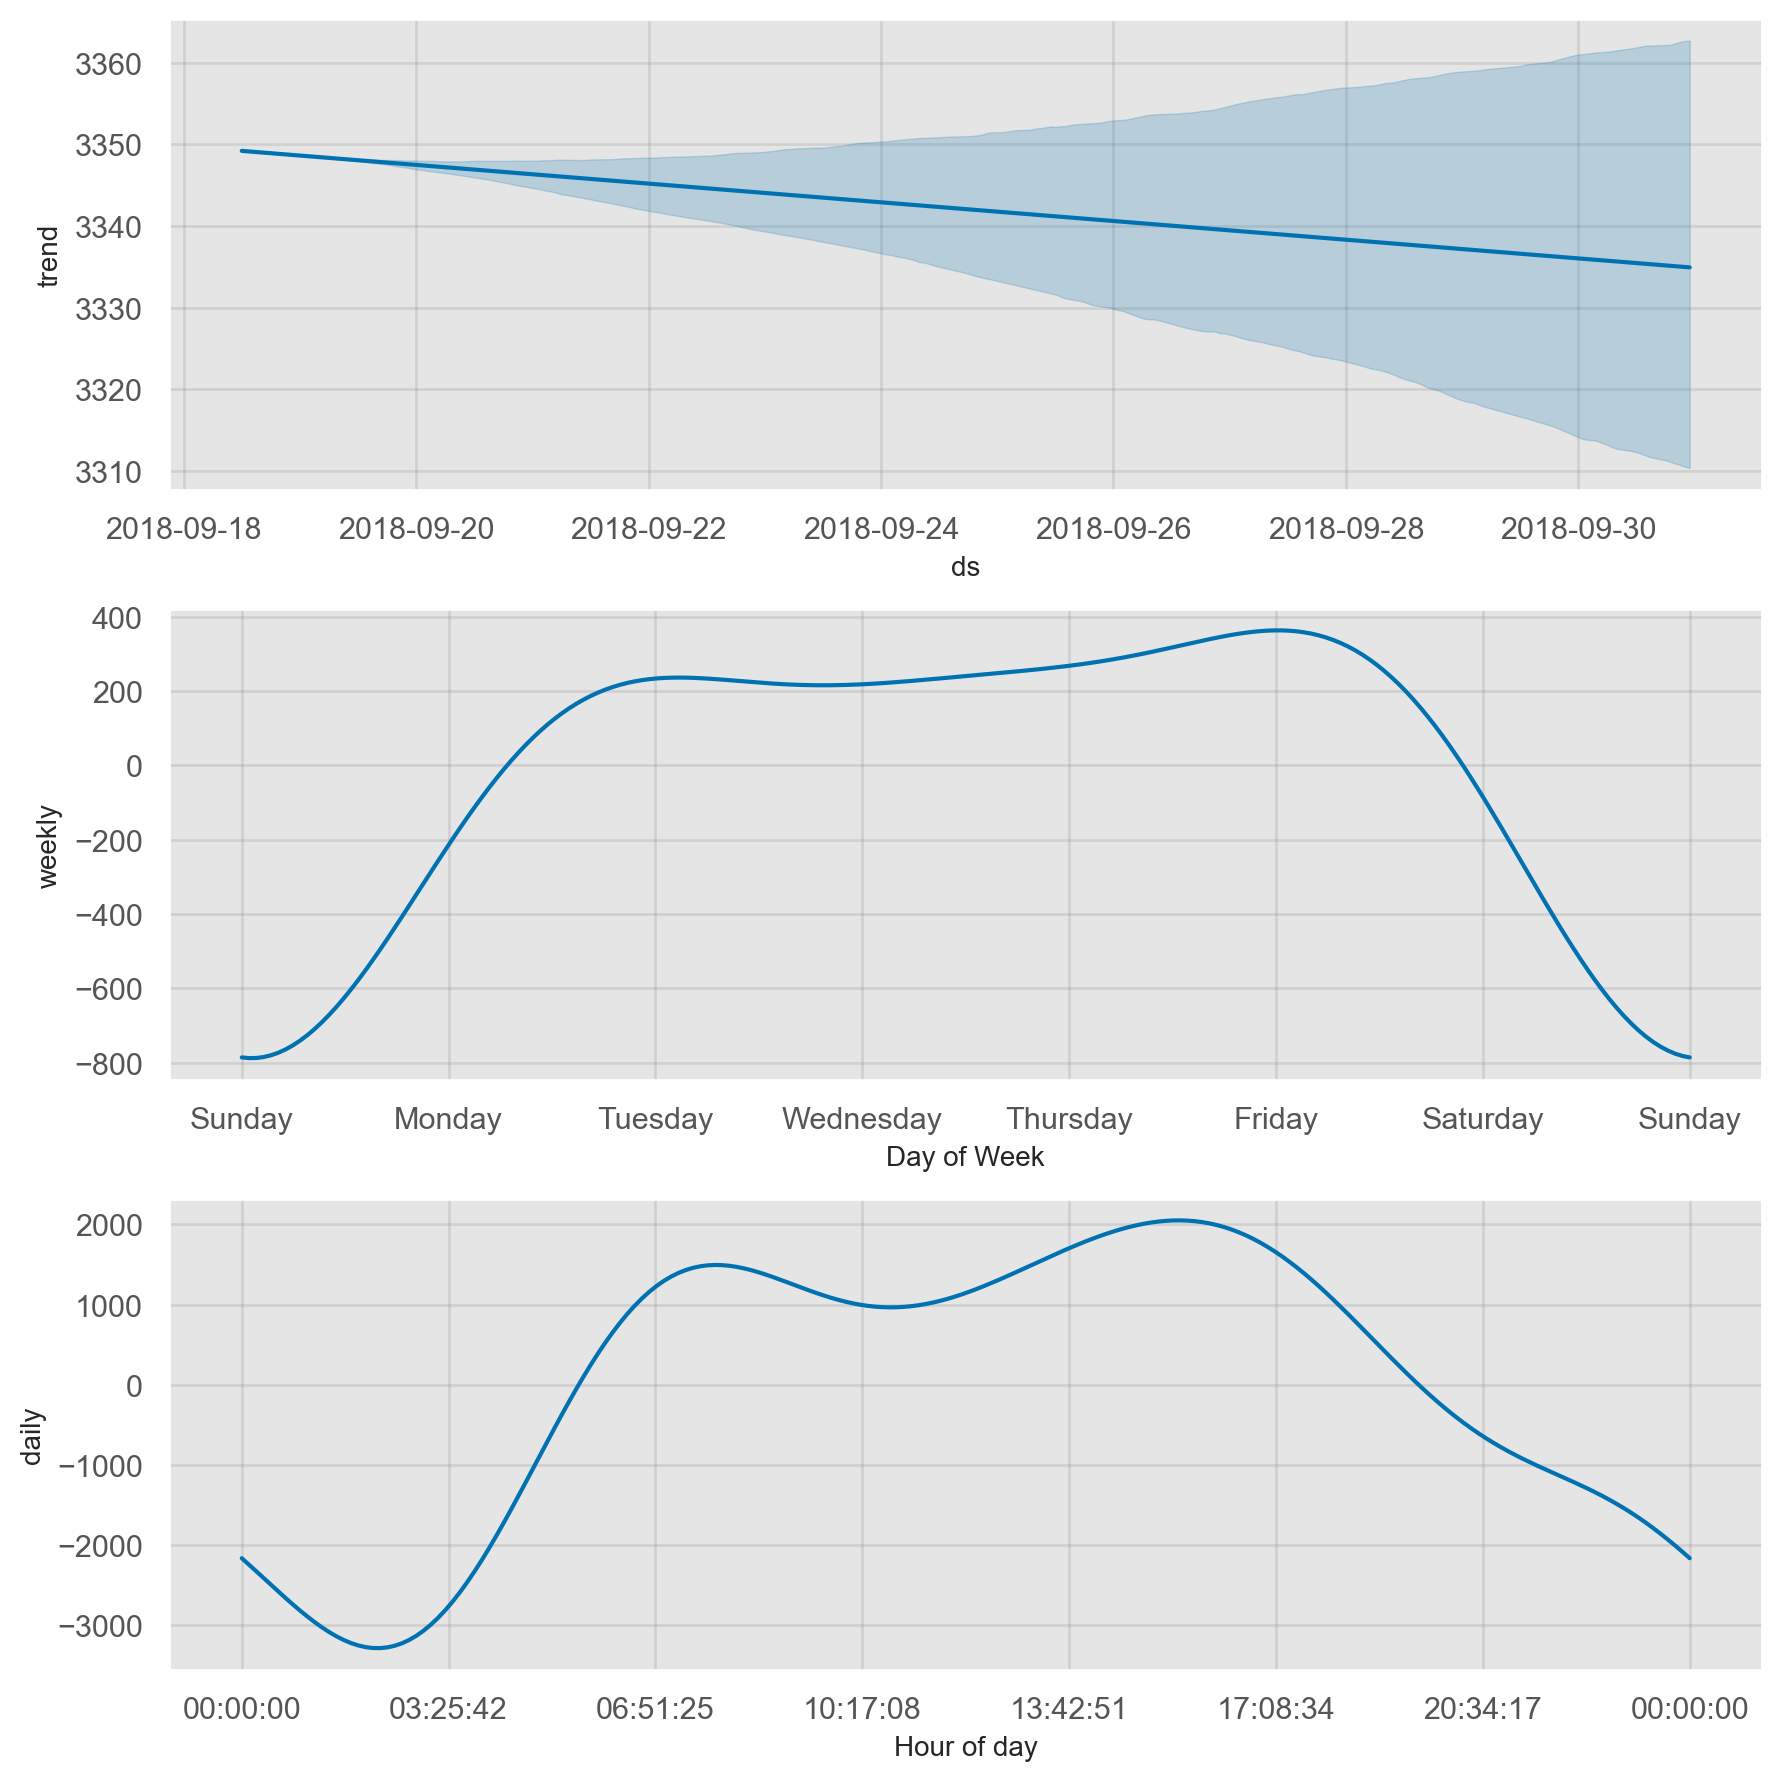

In [78]:
_ = fbmodel.plot_components(forecast)

In [79]:
forecast_pred = forecast['yhat'].copy().astype(np.float32)
forecast_test = fb_y_test['y'].copy().astype(np.float32)
error_metrics(forecast_test, forecast_pred)


Mean Absolute Error: 603.00
Root Mean Squared Error: 804.85
Mean Absolute Percentage Error: nan %


# ARIMA

In [80]:
# !pip install pmdarima

In [81]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

In [82]:
adf_test = ADFTest(alpha=0.5)
adf_test.should_diff(df.traffic_volume)

(0.01, False)

In [83]:
df_arima = pd.DataFrame()
df_arima["ds"] = pd.to_datetime(df.index)
df_arima["y"] = df['traffic_volume'].values

arima_y_train = df_arima.iloc[:-359].copy()
arima_y_test = df_arima.iloc[-359:].copy()
arima_y_val = arima_y_test[["ds"]].copy()

In [84]:
arima_y_train = arima_y_train.drop(['ds'], axis=1)
arima_y_train

y
0     1314.0
1      848.0
2      703.0
3      419.0
4      372.0
...      ...
1844  3208.0
1845  3055.0
1846  2741.0
1847  2123.0
1848  1353.0

[1849 rows x 1 columns]

In [85]:
%%time
arima_model = auto_arima(y_train, m=12,
                        suppress_warnings=True, 
                        stepwise=True,
                        seasonal=True,
                        trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.04 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=33189.352, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=29416.996, Time=0.88 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=30795.952, Time=1.85 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=35754.927, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=29822.227, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=10.83 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=29666.367, Time=0.52 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=27933.177, Time=13.71 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=27926.788, Time=9.19 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=28309.902, Time=4.56 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=6.70 sec
 ARIMA(2,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=10.82 sec
 ARIMA(1,0,1)(2,0,2)[12] interce

In [86]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 1848
Model:             SARIMAX(1, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood              -13956.394
Date:                                 Sun, 01 Oct 2023   AIC                          27926.788
Time:                                         17:13:30   BIC                          27965.441
Sample:                                     07-01-2018   HQIC                         27941.037
                                          - 09-15-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    275.3165     38.592      7.134      0.000     199.677     350.956
ar.L1          0.8434      0.007    113.827      0.000       0.829       0.858
ar.S.L12      -0.1662      0.033     -5.037      0.000      -0.231      -0.101
ar.S.L24       0.6651      0.025     27.146      0.000       0.617       0.713
ma.S.L12       0.0298      0.038      0.781      0.435      -0.045       0.105
ma.S.L24       0.1319      0.030      4.434      0.000       0.074       0.190
sigma2      2.089e+05   4264.481     48.992      0.000    2.01e+05    2.17e+05
===================================================================================
Ljung-Box (L1) (Q):                 389.74   Jarque-Bera (JB):              3742.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             1.13
Prob(H) (two-sided):                  0.28   Kurtosis:                         9.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
prediction = pd.DataFrame(arima_model.predict(n_periods=359))
prediction.columns = ['predicted_traffic_volume']
prediction.head(10)

predicted_traffic_volume
2018-09-16 00:00:00                 1489.3844
2018-09-16 01:00:00                 1267.5907
2018-09-16 02:00:00                 1187.4403
2018-09-16 03:00:00                 1086.8196
2018-09-16 04:00:00                 1130.8446
2018-09-16 05:00:00                 1296.2920
2018-09-16 06:00:00                 1559.7998
2018-09-16 07:00:00                 2029.2757
2018-09-16 08:00:00                 3217.4195
2018-09-16 09:00:00                 3774.3455

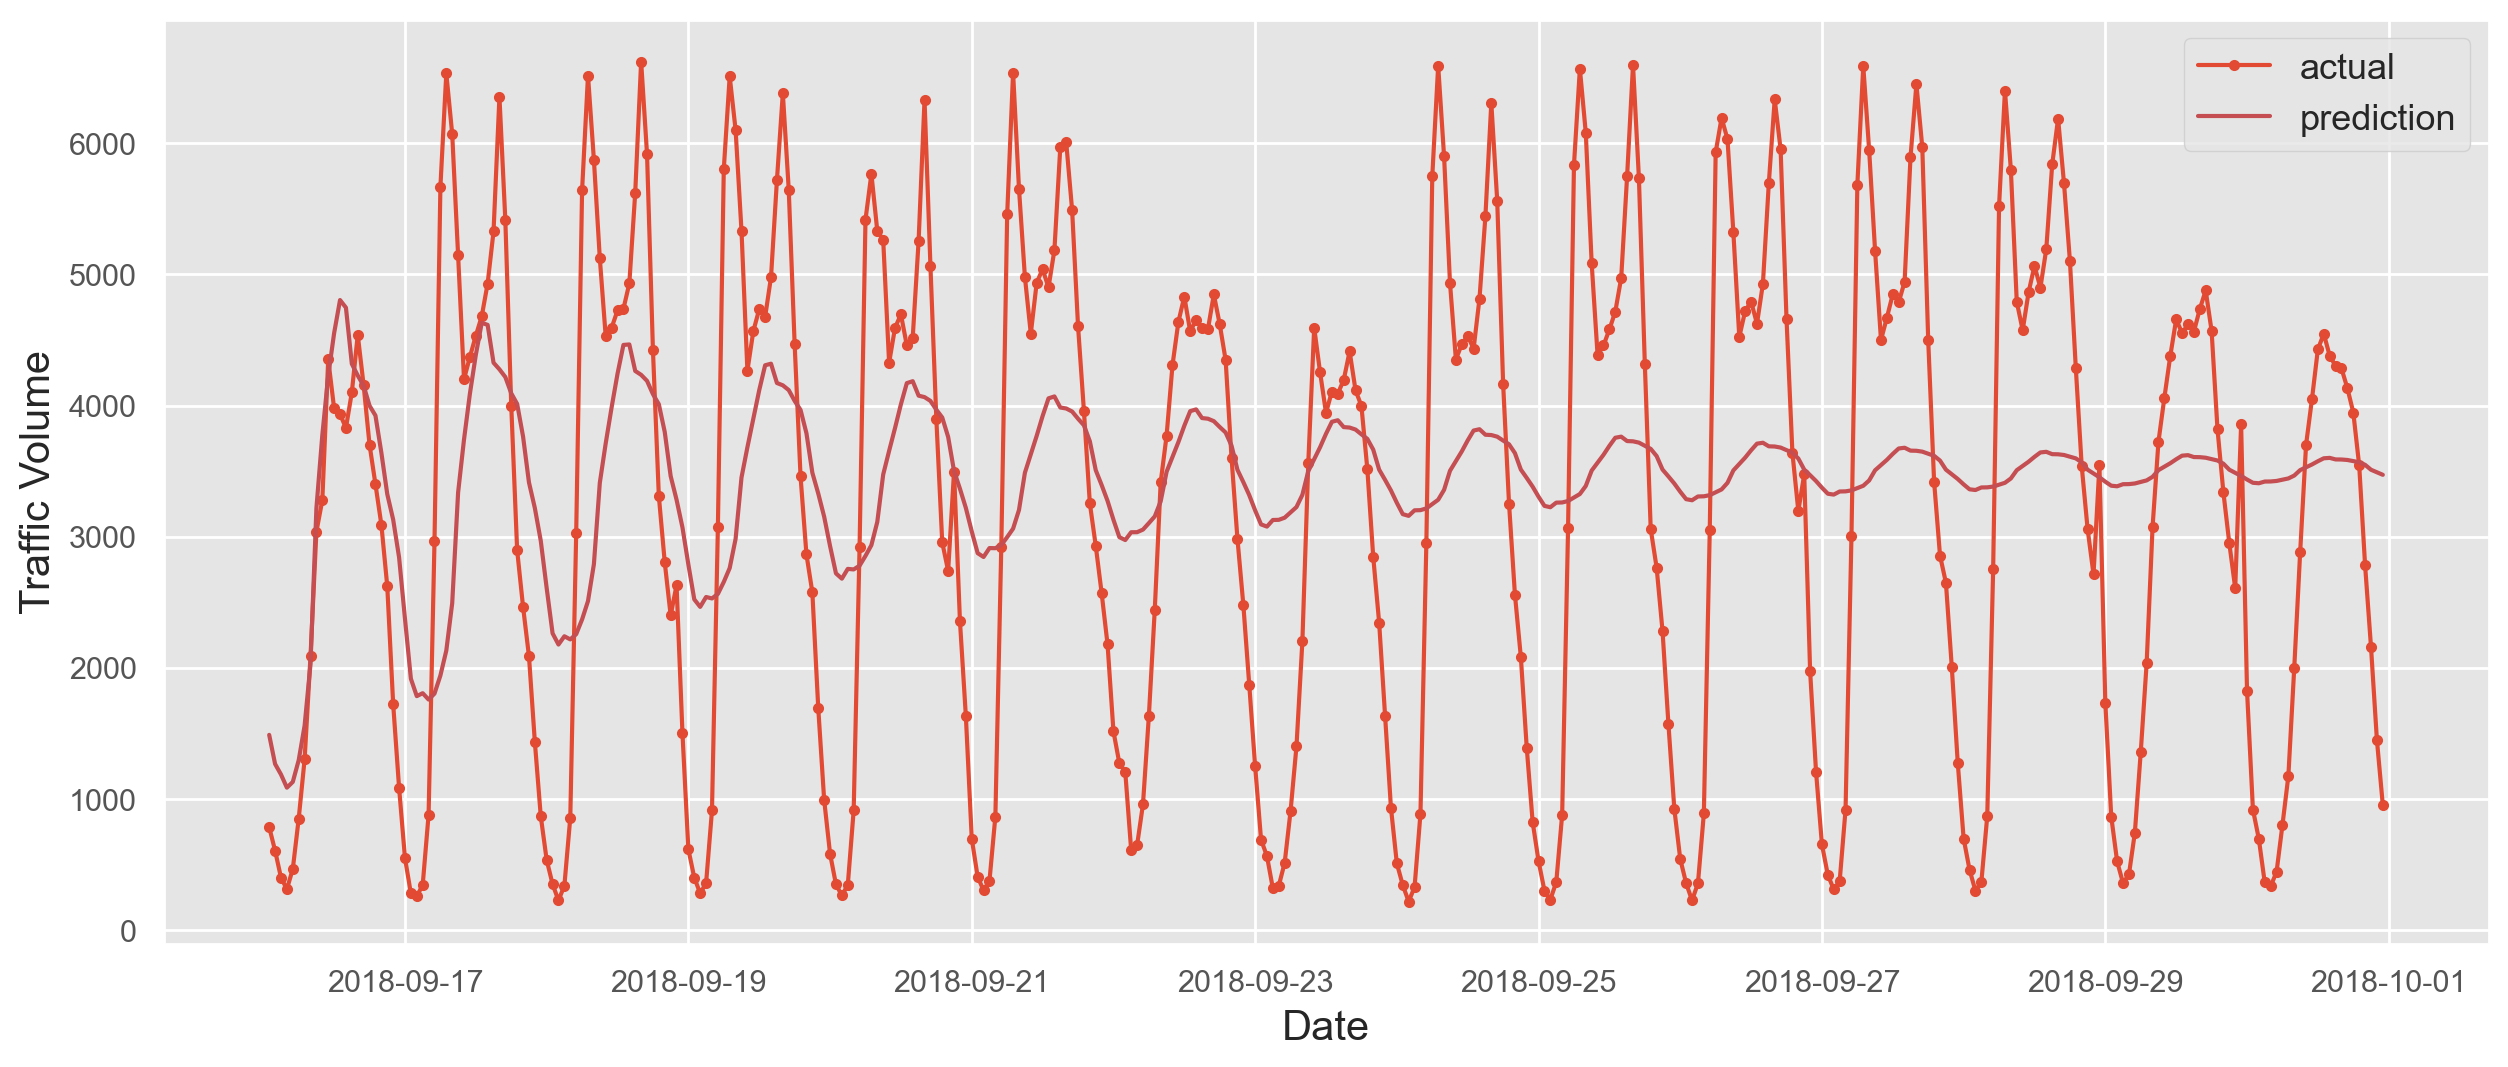

In [88]:
plot_predictions(prediction)

In [89]:
r2_score(y_test, prediction)

0.19585738281481602

In [90]:
print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_test, prediction)))
print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, prediction))))

Mean Absolute Error: 1456.81
Root Mean Squared Error: 1745.24
